In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from tf_agents.environments import tf_py_environment, py_environment, utils
from tf_agents.networks import sequential
from tf_agents.agents.dqn import dqn_agent
from tf_agents.policies import EpsilonGreedyPolicy, random_tf_policy, tf_policy, tf_py_policy, py_policy
from tf_agents.policies.q_policy import QPolicy
from tf_agents.policies.boltzmann_policy import BoltzmannPolicy
from tf_agents.trajectories import trajectory, Trajectory, PolicyStep, time_step as ts
from tf_agents.replay_buffers import TFUniformReplayBuffer
from tf_agents.metrics import tf_metrics
from tf_agents.specs import array_spec
from tf_agents.drivers import dynamic_step_driver
from tf_agents.utils import common
from keras.layers import Dense

In [3]:
from matplotlib import lines

def plot_price_and_loadfactor(data, competition_id, selling_season, run, eval_env=False):
    
    # Create temp dataset for competition id and season
    comp_data = data[
        (data['selling_season'] == selling_season) & 
        (data['competition_id'] == competition_id)
    ].reset_index(drop=True)
    comp_data['loadfactor'] = comp_data['demand'].cumsum() / 80 * 100
    
    # Create plots for price, comp price and loadfactor
    fig, ax1 = plt.subplots(figsize=(16, 6))
    ax2 = ax1.twinx()
    
    lns1 = ax1.plot(comp_data['price'], color='blue', label='Our price')
    lns2 = ax1.plot(comp_data['price_competitor'], color='orange', label='Competitor price')
    lns3 = ax2.plot(comp_data['loadfactor'], color='green', label='Our loadfactor')
    
    ax1.set_ylabel('Price')
    ax2.set_ylabel('Loadfactor (%)')
    ax2.set_ylim(0, 110)
    
    # Add vertical lines where inventory sells out
    if comp_data['loadfactor'].iloc[-1] == 100:
        x = np.where(comp_data['loadfactor'] == 100)[0][0]
        lns4 = lines.Line2D(xdata=[x, x], ydata=[0, 110], color='black', label='Our sellout day')
        lns4 = ax2.add_line(lns4)
        
    if comp_data['competitor_has_capacity'].sum() < 100:
        x = comp_data['competitor_has_capacity'].sum()
        lns5 = lines.Line2D(xdata=[x, x], ydata=[0, 110], color='black', linestyle='--', label='Comp sellout day')
        lns5 = ax2.add_line(lns5)
    
    # Add descriptive info
    plt.title('Price comparison')
    plt.text(.85, .25, 
             (
                 f"Competitor name: {comp_data['competitor_id'][0]} \n " +
                 f"Competition id: {competition_id} \n " +
                 f"Selling season: {selling_season} \n " +
                 f"Total seats sold: {comp_data['demand'].sum()} \n " +
                 f"Total revenue: {(comp_data['demand'] * comp_data['price']).sum()}"
             ),
             bbox={'facecolor':'w','pad':5}, 
             ha="center", va="top", 
             transform=plt.gca().transAxes
            )
    
    # Add labels
    lns = lns1+lns2+lns3
    if comp_data['loadfactor'].iloc[-1] == 100:
        lns = lns+[lns4]
    if comp_data['competitor_has_capacity'].sum() < 100:    
        lns = lns+[lns5]
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc="upper left")

    ax1.xaxis.grid(True)
    plt.grid()

In [4]:
class DynamicPricingCompetition():
    
    """
    A game object where the agent can interact with and that we can update remotely
    to adjust the current state based on recent observations.
    This class also keeps track of all the steps and rewards that took place for later analysis.
    """
    
    def __init__(self):
        self.selling_period = 1
        self.loadfactor = 0
#         self.comp_loadfactor = 0
        self.competitor_has_capacity = 1
        self.price_competitor_t1 = 50
        self.price_competitor_t2 = 50
        self.price_competitor_t3 = 50
        self.price_competitor_t4 = 50
        self.price_competitor_t5 = 50
        self.price_competitor_t6 = 50
        self.price_competitor_t7 = 50
        self.price_competitor_t8 = 50
        self.price_competitor_t9 = 50
        self.price_competitor_t10 = 50
        self.price_t1 = 50
        self.price_t2 = 50
        self.price_t3 = 50
        self.price_t4 = 50
        self.price_t5 = 50
        self.price_t6 = 50
        self.price_t7 = 50
        self.price_t8 = 50
        self.price_t9 = 50
        self.price_t10 = 50
        self.demand_t1 = 1
        self.demand_t2 = 1
        self.demand_t3 = 1
        self.demand_t4 = 1
        self.demand_t5 = 1
        self.demand_t6 = 1
        self.demand_t7 = 1
        self.demand_t8 = 1
        self.demand_t9 = 1
        self.demand_t10 = 1
#         self.demand_competitor_t1 = 1
#         self.demand_competitor_t2 = 1
#         self.demand_competitor_t3 = 1
#         self.demand_competitor_t4 = 1
#         self.demand_competitor_t5 = 1
#         self.demand_competitor_t6 = 1
#         self.demand_competitor_t7 = 1
#         self.demand_competitor_t8 = 1
#         self.demand_competitor_t9 = 1
#         self.demand_competitor_t10 = 1
        self.competition_results_df = pd.DataFrame(columns=[
            'our_strategy',
            'competition_id',
            'selling_season', 
            'selling_period', 
            'competitor_id', 
            'price_competitor', 
            'price', 
            'demand', 
            'competitor_has_capacity', 
            'revenue'
        ])
        
        self.state = [
            self.selling_period,
            self.loadfactor,
#             self.comp_loadfactor,
            self.competitor_has_capacity,
            self.price_competitor_t1,
            self.price_competitor_t2,
            self.price_competitor_t3,
            self.price_competitor_t4,
            self.price_competitor_t5,
            self.price_competitor_t6,
            self.price_competitor_t7,
            self.price_competitor_t8,
            self.price_competitor_t9,
            self.price_competitor_t10,
            self.price_t1,
            self.price_t2,
            self.price_t3,
            self.price_t4,
            self.price_t5,
            self.price_t6,
            self.price_t7,
            self.price_t8,
            self.price_t9,
            self.price_t10,
            self.demand_t1,
            self.demand_t2,
            self.demand_t3,
            self.demand_t4,
            self.demand_t5,
            self.demand_t6,
            self.demand_t7,
            self.demand_t8,
            self.demand_t9,
            self.demand_t10,
#             self.demand_competitor_t1,
#             self.demand_competitor_t2,
#             self.demand_competitor_t3,
#             self.demand_competitor_t4,
#             self.demand_competitor_t5,
#             self.demand_competitor_t6,
#             self.demand_competitor_t7,
#             self.demand_competitor_t8,
#             self.demand_competitor_t9,
#             self.demand_competitor_t10,
        ]
        self._reward = 0
        
    def reset(self):
        self.selling_period = 1
        self.loadfactor = 0
#         self.comp_loadfactor = 0
        self.competitor_has_capacity = 1
        self.price_competitor_t1 = 50
        self.price_competitor_t2 = 50
        self.price_competitor_t3 = 50
        self.price_competitor_t4 = 50
        self.price_competitor_t5 = 50
        self.price_competitor_t6 = 50
        self.price_competitor_t7 = 50
        self.price_competitor_t8 = 50
        self.price_competitor_t9 = 50
        self.price_competitor_t10 = 50
        self.price_t1 = 50
        self.price_t2 = 50
        self.price_t3 = 50
        self.price_t4 = 50
        self.price_t5 = 50
        self.price_t6 = 50
        self.price_t7 = 50
        self.price_t8 = 50
        self.price_t9 = 50
        self.price_t10 = 50
        self.demand_t1 = 1
        self.demand_t2 = 1
        self.demand_t3 = 1
        self.demand_t4 = 1
        self.demand_t5 = 1
        self.demand_t6 = 1
        self.demand_t7 = 1
        self.demand_t8 = 1
        self.demand_t9 = 1
        self.demand_t10 = 1
#         self.demand_competitor_t1 = 1
#         self.demand_competitor_t2 = 1
#         self.demand_competitor_t3 = 1
#         self.demand_competitor_t4 = 1
#         self.demand_competitor_t5 = 1
#         self.demand_competitor_t6 = 1
#         self.demand_competitor_t7 = 1
#         self.demand_competitor_t8 = 1
#         self.demand_competitor_t9 = 1
#         self.demand_competitor_t10 = 1
        
        self.state = [
            self.selling_period,
            self.loadfactor,
#             self.comp_loadfactor,
            self.competitor_has_capacity,
            self.price_competitor_t1,
            self.price_competitor_t2,
            self.price_competitor_t3,
            self.price_competitor_t4,
            self.price_competitor_t5,
            self.price_competitor_t6,
            self.price_competitor_t7,
            self.price_competitor_t8,
            self.price_competitor_t9,
            self.price_competitor_t10,
            self.price_t1,
            self.price_t2,
            self.price_t3,
            self.price_t4,
            self.price_t5,
            self.price_t6,
            self.price_t7,
            self.price_t8,
            self.price_t9,
            self.price_t10,
            self.demand_t1,
            self.demand_t2,
            self.demand_t3,
            self.demand_t4,
            self.demand_t5,
            self.demand_t6,
            self.demand_t7,
            self.demand_t8,
            self.demand_t9,
            self.demand_t10,
#             self.demand_competitor_t1,
#             self.demand_competitor_t2,
#             self.demand_competitor_t3,
#             self.demand_competitor_t4,
#             self.demand_competitor_t5,
#             self.demand_competitor_t6,
#             self.demand_competitor_t7,
#             self.demand_competitor_t8,
#             self.demand_competitor_t9,
#             self.demand_competitor_t10,
        ]
        self._reward = 0
        
    def update_state(self, vars_dict):
        self.selling_period = vars_dict['selling_period']
        self.loadfactor = vars_dict['loadfactor']
#         self.comp_loadfactor = vars_dict['comp_loadfactor']
        self.competitor_has_capacity = vars_dict['competitor_has_capacity']
        self.price_competitor_t1 = vars_dict['price_competitor_t-1']
        self.price_competitor_t2 = vars_dict['price_competitor_t-2']
        self.price_competitor_t3 = vars_dict['price_competitor_t-3']
        self.price_competitor_t4 = vars_dict['price_competitor_t-4']
        self.price_competitor_t5 = vars_dict['price_competitor_t-5']
        self.price_competitor_t6 = vars_dict['price_competitor_t-6']
        self.price_competitor_t7 = vars_dict['price_competitor_t-7']
        self.price_competitor_t8 = vars_dict['price_competitor_t-8']
        self.price_competitor_t9 = vars_dict['price_competitor_t-9']
        self.price_competitor_t10 = vars_dict['price_competitor_t-10']
        self.price_t1 = vars_dict['price_t-1']
        self.price_t2 = vars_dict['price_t-2']
        self.price_t3 = vars_dict['price_t-3']
        self.price_t4 = vars_dict['price_t-4']
        self.price_t5 = vars_dict['price_t-5']
        self.price_t6 = vars_dict['price_t-6']
        self.price_t7 = vars_dict['price_t-7']
        self.price_t8 = vars_dict['price_t-8']
        self.price_t9 = vars_dict['price_t-9']
        self.price_t10 = vars_dict['price_t-10']
        self.demand_t1 = vars_dict['demand_t-1']
        self.demand_t2 = vars_dict['demand_t-2']
        self.demand_t3 = vars_dict['demand_t-3']
        self.demand_t4 = vars_dict['demand_t-4']
        self.demand_t5 = vars_dict['demand_t-5']
        self.demand_t6 = vars_dict['demand_t-6']
        self.demand_t7 = vars_dict['demand_t-7']
        self.demand_t8 = vars_dict['demand_t-8']
        self.demand_t9 = vars_dict['demand_t-9']
        self.demand_t10 = vars_dict['demand_t-10']
#         self.demand_competitor_t1 = vars_dict['demand_competitor_t-1']
#         self.demand_competitor_t2 = vars_dict['demand_competitor_t-2']
#         self.demand_competitor_t3 = vars_dict['demand_competitor_t-3']
#         self.demand_competitor_t4 = vars_dict['demand_competitor_t-4']
#         self.demand_competitor_t5 = vars_dict['demand_competitor_t-5']
#         self.demand_competitor_t6 = vars_dict['demand_competitor_t-6']
#         self.demand_competitor_t7 = vars_dict['demand_competitor_t-7']
#         self.demand_competitor_t8 = vars_dict['demand_competitor_t-8']
#         self.demand_competitor_t9 = vars_dict['demand_competitor_t-9']
#         self.demand_competitor_t10 = vars_dict['demand_competitor_t-10']
        
        self.state = [
            self.selling_period,
            self.loadfactor,
#             self.comp_loadfactor,
            self.competitor_has_capacity,
            self.price_competitor_t1,
            self.price_competitor_t2,
            self.price_competitor_t3,
            self.price_competitor_t4,
            self.price_competitor_t5,
            self.price_competitor_t6,
            self.price_competitor_t7,
            self.price_competitor_t8,
            self.price_competitor_t9,
            self.price_competitor_t10,
            self.price_t1,
            self.price_t2,
            self.price_t3,
            self.price_t4,
            self.price_t5,
            self.price_t6,
            self.price_t7,
            self.price_t8,
            self.price_t9,
            self.price_t10,
            self.demand_t1,
            self.demand_t2,
            self.demand_t3,
            self.demand_t4,
            self.demand_t5,
            self.demand_t6,
            self.demand_t7,
            self.demand_t8,
            self.demand_t9,
            self.demand_t10,
#             self.demand_competitor_t1,
#             self.demand_competitor_t2,
#             self.demand_competitor_t3,
#             self.demand_competitor_t4,
#             self.demand_competitor_t5,
#             self.demand_competitor_t6,
#             self.demand_competitor_t7,
#             self.demand_competitor_t8,
#             self.demand_competitor_t9,
#             self.demand_competitor_t10,
        ]
        self._reward = 0
        
    def update_reward(self, reward):
        self.reward = reward

In [5]:
class CreateAirlineSimulation():
    
    def __init__(self, demand_set_price=None, demand_exp_factor=None, price_sensitivity_factor=None, 
                 competitiveness_score=None, our_stock=80, comp_stock=80):
        """
        Class is used to simulate the demand for flight tickets.

        Attributes:
            demand_set_price: Starting/opening price which would result in lambda 1 (~1 demand when prices are all equal)
            demand_exp_factor: Exponential factor that increases the price demand every period
            price_sensitivity_factor: How important pricing is in demand for this season
            competitiveness_score: How importance price difference with competitor is for this season
        """
        self.period = 1
        self.our_stock = our_stock
        self.comp_stock = comp_stock
        self.demand_set_price = demand_set_price
        self.demand_exp_factor = demand_exp_factor
        self.price_sensitivity_factor = price_sensitivity_factor
        self.competitiveness_score = competitiveness_score
        self.demand_curve_prices = []
        self._initialize_demand_curve()
    
    def _initialize_demand_curve(self):
        """
        Initialize demand curve and environment characteristics.
        """
        
        if self.demand_set_price is None:
            self.demand_set_price = np.random.normal(50, 10)
            
        if self.demand_exp_factor is None:
            self.demand_exp_factor = np.random.normal(1.005, 0.001)
            
        if self.price_sensitivity_factor is None:
            self.price_sensitivity_factor = np.random.normal(1.1, 0.05)
            
        if self.competitiveness_score is None:
            self.competitiveness_score = np.random.normal(1.1, 0.05)
        
        self.demand_curve_prices = np.array([
            self.exp_increase(self.demand_set_price, self.demand_exp_factor, x) for x in range(1, 101)
        ])
    
    @staticmethod
    def exp_increase(start_point, exp_inc, timestep):
        """
        Calculates exponential increase based on timestep.
        """
        return start_point * exp_inc**(timestep-1)
    
    @staticmethod
    def calculate_lambdas(demand_set_price, our_price, comp_price, price_sensitivity_factor, competitiveness_score):
        """
        Given your price, and the price of competitor, you will pull demand from a certain distribution.
        The distribution is a poisson distribution which uses lambda as input to determine the distribution.

        Lambda must be a relative score depending on:
        Our prices relative to demand curve
        Our price relative to competition
        Price sensitivity of market (price elastivity)
        Competitiveness of the market
        """

        # Set lambda based on price diff with set price
        our_lambda = 1 + (demand_set_price - our_price) / our_price
        comp_lambda = 1 + (demand_set_price - comp_price) / comp_price

        # Adjust for price sensitivity
        if our_price > demand_set_price:
            our_lambda = our_lambda / price_sensitivity_factor
        else:
            our_lambda = our_lambda * price_sensitivity_factor

        if comp_price > demand_set_price:
            comp_lambda = comp_lambda / price_sensitivity_factor
        else:
            comp_lambda = comp_lambda * price_sensitivity_factor

        # Adjust for price difference and how competitive this market is
        if our_price > comp_price:
            our_lambda = our_lambda / (1 + (our_price - comp_price) / comp_price) / competitiveness_score
            comp_lambda = comp_lambda / (1 + (comp_price - our_price) / our_price) * competitiveness_score
        else:
            our_lambda = our_lambda / (1 + (our_price - comp_price) / comp_price) * competitiveness_score
            comp_lambda = comp_lambda / (1 + (comp_price - our_price) / our_price) / competitiveness_score

        return our_lambda, comp_lambda
    
    def simulate_demand(self, our_price, comp_price):
        """
        Use our price and price of competitor to simulate demand
        Checks demand with current stock and returns demand
        """
        # Create lambdas to define the distribution from which the demand will be picked
        our_lambda, comp_lambda = self.calculate_lambdas(
            self.demand_set_price, our_price, comp_price, self.price_sensitivity_factor, self.competitiveness_score
        )
        
        # Pick the actual demand
        our_demand = np.random.poisson(lam=our_lambda, size=1)
        comp_demand = np.random.poisson(lam=comp_lambda, size=1)
        
        # Check if demand can be met, i.e. there is stock left
        if our_demand > self.our_stock:
            our_demand = [self.our_stock]
            
        if comp_demand > self.comp_stock:
            comp_demand = [self.comp_stock]
            
        self.update_environment(our_demand, comp_demand)
        
        return our_demand, comp_demand
    
    def update_environment(self, our_demand, comp_demand):
        """
        Update environment variables to be ready for next period simulation.
        """
        
        # reset if simulation finished
        if self.period == 100:
            self.reset_environment()
        # Update period, stock and set price otherwise
        else:
            self.period += 1
            self.our_stock -= our_demand[0]
            self.comp_stock -= comp_demand[0]
            self.demand_set_price = self.demand_curve_prices[self.period-1]
            
    def reset_environment(self):
        self.period = 1
        self.our_stock = 80
        self.comp_stock = 80
        self.demand_set_price=None
        self.demand_exp_factor=None
        self.price_sensitivity_factor=None 
        self.competitiveness_score=None
        self._initialize_demand_curve()

In [6]:
class CompStrategySimulation():
    """
    Competitor stratagies that have been seen and are relatively easy to implement.c
    'follower_strategy' wil start with a random price for the first 10 periods, 
    then use the price we set 2 days ago, 'random_ranges' will always pick a random price
    between a higher and lower bound, and 'highstart_randomranges' will start with a high price (e.g. 100)
    and then lower after an x number of days to move between boundaries.
    """
    
    def __init__(self, strategy):
        self.strategy = strategy
        self.period = 1
        self.lower_bound = np.random.randint(40, 60)
        self.upper_bound = np.random.randint(60, 90)
        self.fixed_price = np.random.randint(40, 80)
        self.hist_comp_price = []
        self.high_start_nr_days = None
        self.exp1, self.exp2 = np.nan, np.nan
        self.begin, self.end = np.nan, np.nan
        self.price_points = []
        
    def pick_pricepoint(self, last_comp_price):
        """
        Use the chosen strategy to return a price point for the current period.
        """
        if self.strategy == 'random_ranges':
            return_price = np.random.randint(self.lower_bound, self.upper_bound)
            self.update_environment(last_comp_price)
            return return_price
        elif self.strategy == 'highstart_randomranges':
            if self.period == 1:
                self.high_start_nr_days = np.random.randint(25, 50)
                return_price = 100
                self.update_environment(last_comp_price)
                return return_price
            elif self.period >= self.high_start_nr_days:
                return_price = np.random.randint(self.lower_bound, self.upper_bound)
                self.update_environment(last_comp_price)
                return return_price
            else:
                return_price = 100
                self.update_environment(last_comp_price)
                return return_price
        elif self.strategy == 'follower_strategy':
            if self.period <= 10:
                return_price = np.random.randint(self.lower_bound, self.upper_bound)
                self.update_environment(last_comp_price)
                return return_price
            else:
                return_price = self.hist_comp_price[-2]
                self.update_environment(last_comp_price)
                return return_price
        elif self.strategy == 'fixed_price':
            return_price = self.fixed_price
            self.update_environment(last_comp_price)
            return return_price
        elif self.strategy == 'linear_increase':
            return_price = self.lower_bound + (self.upper_bound - self.lower_bound) / 100 * self.period
            self.update_environment(return_price)
            return return_price
        elif self.strategy == 'random_curve':
            if self.period == 1:
                self.rc_precalc_price_path()
            return_price = self.price_points[self.period-1]
            self.update_environment(last_comp_price)
            return return_price
        else:
            raise ValueError('Strategy should be either of ['
                             '"follower_strategy", "random_ranges", "highstart_randomranges", '
                             '"fixed_price", "linear_increase", "random_curve"'
                             ']')
            
    def update_environment(self, last_comp_price):
        """
        Update environment variables to be ready for next period simulation.
        """
        # reset if simulation finished
        if self.period == 100:
            self.period = 1
            self.lower_bound = np.random.randint(40, 60)
            self.upper_bound = np.random.randint(60, 90)
            self.fixed_price = np.random.randint(40, 80)
            self.hist_comp_price = []
            self.high_start_nr_days = None
        else:
            # update env variables otherwise
            self.period += 1  
            self.hist_comp_price.append(last_comp_price)
            
    def rc_precalc_price_path(self):
        self.exp1 = np.random.normal(1.02, 0.015)
        self.exp2 = np.random.normal(1.02, 0.015)
        self.begin = np.random.normal(60, 10)
        self.end = np.random.normal(100, 10)
        self.price_points = tf.constant(self.create_scaled_polynomial_curve(self.begin, self.end, 100, self.exp1, self.exp2))
    
    @staticmethod
    def polynomial_increase(start_point, factor1, factor2, timestep):
        return start_point + factor1**timestep - factor2**(100-timestep)

    @staticmethod
    def create_scaled_polynomial_curve(start_point, endpoint, dbd_range, factor1, factor2):
        initial_curve = [
            CompStrategySimulation.polynomial_increase(start_point, factor1, factor2, x) for x in range(dbd_range)
        ]
        second_curve = [x + start_point - min(initial_curve) for x in initial_curve]
        third_curve = [x / (max(second_curve) / endpoint) for x in second_curve]

        return third_curve

In [7]:
# Environment in which the agent operates in, and is protected from altering
class AirlineEnvironment(py_environment.PyEnvironment):
    
    def __init__(self, dpc_game, simulator, num_features, num_actions, discount, min_action, 
                 action_step, comp_sellout_price, early_termination_penalty=0, price_diff_penalty=0, 
                 loadfactor_diff_penalty=0, stock_remainder_penalty=0):
        """
        Initialize what actions the agent can take,
        and what the observation space will look like.
        
        Also initialize the environment where the agent will interact with.
        """
        self._action_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=num_actions-1, name='action'
        )
        self._observation_spec = array_spec.BoundedArraySpec(
            shape=(num_features,), dtype=np.int32, name='observation'
        )
        self._selling_season = 1
        self._episode_ended = False
        self._discount = discount
        self._dpc_game = dpc_game
        self._simulator = simulator
        self._min_action = min_action
        self._action_step = action_step
        self._comp_sellout_price = comp_sellout_price
        self._early_termination_penalty = early_termination_penalty
        self._price_diff_penalty = price_diff_penalty
        self._loadfactor_diff_penalty = loadfactor_diff_penalty
        self._stock_remainder_penalty = stock_remainder_penalty
        
    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec
    
    def current_time_step(self):
        return self._current_time_step

    def reset(self):
        self._current_time_step = self._reset()
        return self._current_time_step

    def step(self, action):
        self._current_time_step = self._step(action)
        return self._current_time_step

    def _reset(self):
        self._selling_season += 1
        self._episode_ended = False
        self._dpc_game.reset()
        self._simulator.reset_environment()
        return ts.restart(np.array(self._dpc_game.state, dtype=np.int32))

    def _step(self, action):
        
        if self._episode_ended:
            # The last action ended the episode. Ignore the current action and start a new episode.
            return self.reset()
        
        self._our_demand = self._simulator.get_demand()

        self._reward = self._our_demand * self._simulator._our_price
        
        add_row = {
            'our_strategy': 'dqnagent',
            'competition_id': 'dqnagent' + str(self._selling_season),
            'selling_season': self._selling_season, 
            'selling_period': self._dpc_game.selling_period, 
            'competitor_id': comp_strat, 
            'price_competitor': last_comp_price, 
            'price': self._simulator._our_price, 
            'demand': self._our_demand, 
            'competitor_has_capacity': competitor_has_capacity, 
            'revenue': self._reward
        }
        
        self._dpc_game.competition_results_df = self._dpc_game.competition_results_df.append(add_row, ignore_index=True)
        
        # Update states
        vars_dict = {
            'selling_period': self._simulator._selling_period,
            'loadfactor': 80 - self._simulator._our_stock,
#             'comp_loadfactor': 80 - self._simulator.comp_stock,
            'competitor_has_capacity': self._simulator._competitor_has_capacity,
            'price_competitor_t-1': self._simulator._comp_price,
            'price_competitor_t-2': self._dpc_game.price_competitor_t1,
            'price_competitor_t-3': self._dpc_game.price_competitor_t2,
            'price_competitor_t-4': self._dpc_game.price_competitor_t3,
            'price_competitor_t-5': self._dpc_game.price_competitor_t4,
            'price_competitor_t-6': self._dpc_game.price_competitor_t5,
            'price_competitor_t-7': self._dpc_game.price_competitor_t6,
            'price_competitor_t-8': self._dpc_game.price_competitor_t7,
            'price_competitor_t-9': self._dpc_game.price_competitor_t8,
            'price_competitor_t-10': self._dpc_game.price_competitor_t9,
            'price_t-1': self._simulator._our_price,
            'price_t-2': self._dpc_game.price_t1,
            'price_t-3': self._dpc_game.price_t2,
            'price_t-4': self._dpc_game.price_t3,
            'price_t-5': self._dpc_game.price_t4,
            'price_t-6': self._dpc_game.price_t5,
            'price_t-7': self._dpc_game.price_t6,
            'price_t-8': self._dpc_game.price_t7,
            'price_t-9': self._dpc_game.price_t8,
            'price_t-10': self._dpc_game.price_t9,
            'demand_t-1': self._our_demand,
            'demand_t-2': self._dpc_game.demand_t1,
            'demand_t-3': self._dpc_game.demand_t2,
            'demand_t-4': self._dpc_game.demand_t3,
            'demand_t-5': self._dpc_game.demand_t4,
            'demand_t-6': self._dpc_game.demand_t5,
            'demand_t-7': self._dpc_game.demand_t6,
            'demand_t-8': self._dpc_game.demand_t7,
            'demand_t-9': self._dpc_game.demand_t8,
            'demand_t-10': self._dpc_game.demand_t9,
#             'demand_competitor_t-1': self._comp_demand[0],
#             'demand_competitor_t-2': self._dpc_game.demand_competitor_t1,
#             'demand_competitor_t-3': self._dpc_game.demand_competitor_t2,
#             'demand_competitor_t-4': self._dpc_game.demand_competitor_t3,
#             'demand_competitor_t-5': self._dpc_game.demand_competitor_t4,
#             'demand_competitor_t-6': self._dpc_game.demand_competitor_t5,
#             'demand_competitor_t-7': self._dpc_game.demand_competitor_t6,
#             'demand_competitor_t-8': self._dpc_game.demand_competitor_t7,
#             'demand_competitor_t-9': self._dpc_game.demand_competitor_t8,
#             'demand_competitor_t-10': self._dpc_game.demand_competitor_t9,
        }
        
        self._dpc_game.update_state(vars_dict)
        self._dpc_game.update_reward(self._reward)
        
        # Make sure episodes don't go on forever.
        if self._dpc_game.state[0] == 100:
            # Add additional penalty for ending the season with high stock left
            self._episode_ended = True
            return ts.termination(
                np.array(self._dpc_game.state, dtype=np.int32), 
                self._reward - self._stock_remainder_penalty * self._simulator._our_stock
            )
        elif self._dpc_game.loadfactor >= 80:
            # Add additional penalty for ending the season early (higher penalty longer in advance)
            self._episode_ended = True
            return ts.termination(
                np.array(self._dpc_game.state, dtype=np.int32), 
                self._reward - self._early_termination_penalty * (100 - self._dpc_game.state[0])
            )
        else:
            # Add additional penalty for changing prices by a lot
            price_diff_penal = abs(self._simulator._our_price - self._dpc_game.price_t1)**2 * self._price_diff_penalty
            # Add additional penaly for selling out too quickly
            load_diff = abs(self._dpc_game.loadfactor - (0.8 * self._dpc_game.state[0]))
            load_diff_penalty = load_diff**2 * self._loadfactor_diff_penalty
            
            return ts.transition(
                np.array(self._dpc_game.state, dtype=np.int32), 
                reward=self._reward - price_diff_penal - load_diff_penalty, 
                discount=self._discount
            )

In [8]:
class ExternalSimulator():
    
    def __init__(self):
        self._selling_period = 1
        self._our_stock = 80
        self._our_price = 50
        self._our_comp_price = 50
        self._competitor_has_capacity = True
        self._last_demand = 1
        
    def get_demand(self):
        return self._last_demand
        
    def update(self, last_price, last_comp_price, last_demand, competitor_has_capacity):
        self._selling_period += 1
        self._our_stock -= last_demand
        self._our_price = last_price
        self._comp_price = last_comp_price
        self._last_demand = last_demand
        self._competitor_has_capacity = competitor_has_capacity
        
    def reset_environment(self):
        self._selling_period = 1
        self._our_stock = 80
        self._our_price = 50
        self._comp_price = 50
        self._competitor_has_capacity = True
        self._last_demand = 1

In [9]:
# Settings
max_action = 150
min_action = 30
action_price_step = 3
num_actions = (max_action-min_action) / action_price_step
num_features = 33

discount = 1.0
comp_sellout_price = 120
early_termination_penalty = 10
price_diff_penalty = 0.1
loadfactor_diff_penalty = 0.2
stock_remainder_penalty = 50

hidden_units_layer1 = 20
hidden_units_layer2 = 40
learning_rate = 1e-3
beta_1 = 0.9
beta_2 = 0.999
target_update_period = 2000

policy = 'boltzmann_temperature'
exponential_decay_rate = 1.0
boltzmann_temperature_start = 100.0
boltzmann_temperature_end = 1.0
epsilon_greedy_start = 1.0
epsilon_greedy_end = 0.01
decay_steps = 5 * 1000 * 100

replay_buffer_batch_size = 1
replay_buffer_max_size = 10000
sample_batch_size = 64
num_steps = 2
num_parallel_calls = 4

seed = 123
tf.random.set_seed(seed)

In [10]:
dpc_game = DynamicPricingCompetition()
simulator = CreateAirlineSimulation()
ext_simulator = ExternalSimulator()
environment = AirlineEnvironment(dpc_game, ext_simulator, num_features, num_actions, discount, 
                                 min_action, action_price_step, comp_sellout_price, 
                                 early_termination_penalty, price_diff_penalty, loadfactor_diff_penalty,
                                 stock_remainder_penalty)
#utils.validate_py_environment(environment, episodes=5)
train_env = tf_py_environment.TFPyEnvironment(environment)

In [11]:
# Set up the agent and the network for the agent
init = tf.keras.initializers.HeUniform()
layer1 = Dense(units=hidden_units_layer1, input_shape=(num_features,), activation='relu',
               kernel_initializer=init, name='hidden_layer1')
layer2 = Dense(units=hidden_units_layer2, activation='relu', kernel_initializer=init, name='hidden_layer2')
layer3 = Dense(units=num_actions, activation=None, kernel_initializer=init)
q_net = sequential.Sequential([layer1, layer2, layer3])

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2)

train_step_counter = tf.Variable(0)

if policy == 'boltzmann_temperature':
    if exponential_decay_rate == 1:
        epsilon_fn = tf.keras.optimizers.schedules.PolynomialDecay(
                        initial_learning_rate=boltzmann_temperature_start,
                        decay_steps=decay_steps,
                        end_learning_rate=boltzmann_temperature_end)
    else:
        epsilon_fn = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=boltzmann_temperature_start,
            decay_steps=decay_steps,
            decay_rate=exponential_decay_rate,
        )

    agent = dqn_agent.DqnAgent(
        time_step_spec=train_env.time_step_spec(),
        action_spec=train_env.action_spec(),
        q_network=q_net,
        optimizer=optimizer,
        target_update_period=target_update_period,
        td_errors_loss_fn=tf.keras.losses.Huber(reduction="none"),
        gamma=discount,
        boltzmann_temperature=lambda: epsilon_fn(train_step_counter),
        epsilon_greedy=None,
        train_step_counter=train_step_counter
    )
elif policy == 'epsilon_greedy':
    if exponential_decay_rate == 1:
        epsilon_fn = tf.keras.optimizers.schedules.PolynomialDecay(
                        initial_learning_rate=epsilon_greedy_start,
                        decay_steps=decay_steps,
                        end_learning_rate=epsilon_greedy_end)
    else:
        epsilon_fn = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=epsilon_greedy_start,
            decay_steps=decay_steps,
            decay_rate=exponential_decay_rate,
        )

    agent = dqn_agent.DqnAgent(
        time_step_spec=train_env.time_step_spec(),
        action_spec=train_env.action_spec(),
        q_network=q_net,
        optimizer=optimizer,
        target_update_period=target_update_period,
        td_errors_loss_fn=tf.keras.losses.Huber(reduction="none"),
        gamma=discount,
        epsilon_greedy=lambda: epsilon_fn(train_step_counter),
        train_step_counter=train_step_counter
    )

agent.initialize()

In [12]:
# replay buffer and driver for training
replay_buffer = TFUniformReplayBuffer(
    agent.collect_data_spec,
    batch_size=replay_buffer_batch_size,
    max_length=replay_buffer_max_size
)

replay_buffer_observer = replay_buffer.add_batch
train_metrics = [tf_metrics.AverageReturnMetric()]

In [13]:
# # Make reusing a model possible
# train_checkpointer = common.Checkpointer(
#     ckpt_dir='checkpoint_agents',
#     max_to_keep=1,
#     agent=agent,
#     policy=agent.policy,
#     replay_buffer=replay_buffer,
#     global_step=train_step_counter
# )

In [14]:
# Setup training
dataset = replay_buffer.as_dataset(
    sample_batch_size= sample_batch_size,
    num_steps=num_steps,
    num_parallel_calls=num_parallel_calls
).prefetch(num_parallel_calls)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [15]:
agent.train = common.function(agent.train)

In [16]:
dpc_game.reset()
dpc_game.competition_results_df = pd.DataFrame()
simulator.reset_environment()
ext_simulator.reset_environment()

In [16]:
comp_strat = np.random.choice(
    a=["random_ranges", "highstart_randomranges", "follower_strategy", "fixed_price", "linear_increase", "random_curve"],
    p=[0.05, 0.05, 0.1, 0.2, 0.3, 0.3]
)
comp_strategy = CompStrategySimulation(comp_strat)

#print(f'Competitor strategy: {comp_strat}')

time_step = train_env.reset()
policy_state = agent.collect_policy.get_initial_state(train_env.batch_size)
iterator = iter(dataset)
last_comp_price = 50

action_step = agent.collect_policy.action(time_step)
last_price = min_action + int(action_step.action) * action_price_step

#print(f'First action is {int(action_step.action)}, thus price is set to {price}')

prev_step = time_step
prev_action_step = action_step

for i in range(1000 * 100):
    
    if i % 1000 == 0:
        print(f'Start iteration {i}')
    
    last_comp_price = comp_strategy.pick_pricepoint(last_comp_price)
    last_demand, _ = simulator.simulate_demand(last_price, last_comp_price)
    #print(f'Demand with price {last_price} and comp price {last_comp_price} is {last_demand}')
    competitor_has_capacity = dpc_game.competitor_has_capacity

    ext_simulator.update(last_price, last_comp_price, last_demand[0], competitor_has_capacity)
    time_step = train_env.step(action_step)
    action_step = agent.collect_policy.action(time_step)
    last_price = min_action + int(action_step.action) * action_price_step
    #print(f'Period {dpc_game.selling_period}, action is {int(action_step.action)}, thus price is set to {price}')
    
    # Add trajectory and adding to replay buffer + training
    traj = Trajectory(
        prev_step.step_type,
        prev_step.observation,
        prev_action_step.action,
        prev_action_step.info,
        time_step.step_type,
        time_step.reward,
        time_step.discount
    )
    replay_buffer.add_batch(traj)

    # Save step and action for the next round
    prev_step = time_step
    prev_action_step = action_step  
    
    if int(time_step.step_type) == 2:
        #print('End of episode, reset env')
        comp_strat = np.random.choice(
            a=["random_ranges", "highstart_randomranges", "follower_strategy", "fixed_price", "linear_increase", "random_curve"],
            p=[0.05, 0.05, 0.1, 0.2, 0.3, 0.3]
        )
        comp_strategy = CompStrategySimulation(comp_strat)
        simulator.reset_environment()
    
    if replay_buffer.num_frames() > 5000:
        trajectories, _ = next(iterator)
        loss = agent.train(experience=trajectories)

Start iteration 0
Start iteration 1000
Start iteration 2000
Start iteration 3000
Start iteration 4000
Start iteration 5000
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
Start iteration 6000
Start iteration 7000
Start iteration 8000
Start iteration 9000
Start iteration 10000
Start iteration 11000
Start iteration 12000
Start iteration 13000
Start iteration 14000
Start iteration 15000
Start iteration 16000
Start iteration 17000
Start iteration 18000
Start iteration 19000
Start iteration 20000
Start iteration 21000
Start iteration 22000
Start iteration 23000
Start iteration 24000
Start iteration 25000
Start iteration 26000
Start iteration 27000
Start iteration 28000
Start iteration 29000
Start iteration 30000
Start iteration 31000
Start iteration 32000
Start iteration 33000
Start iteration 34000
Start ite

In [17]:
epsilon_fn(train_step_counter)

<tf.Tensor: shape=(), dtype=float32, numpy=81.19>

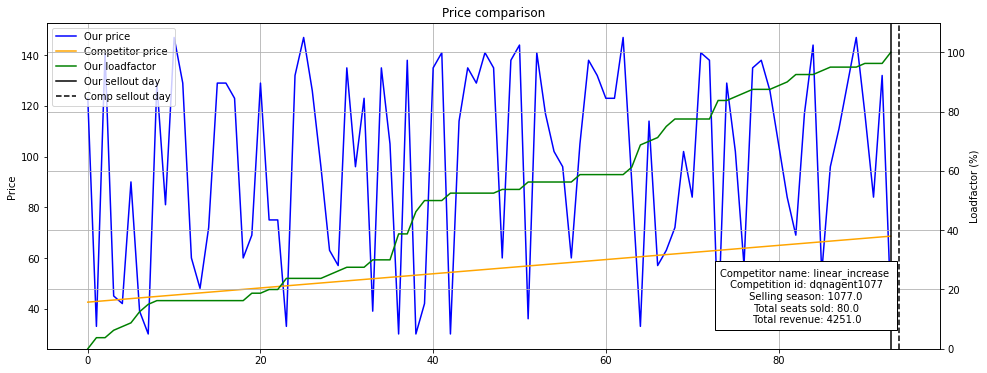

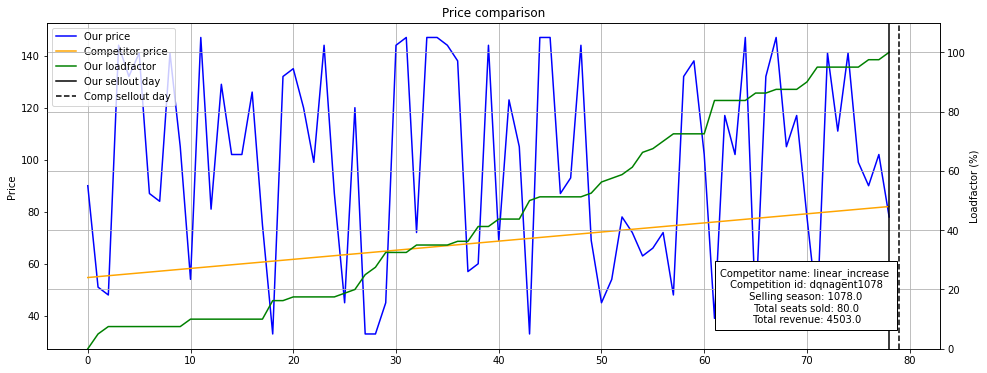

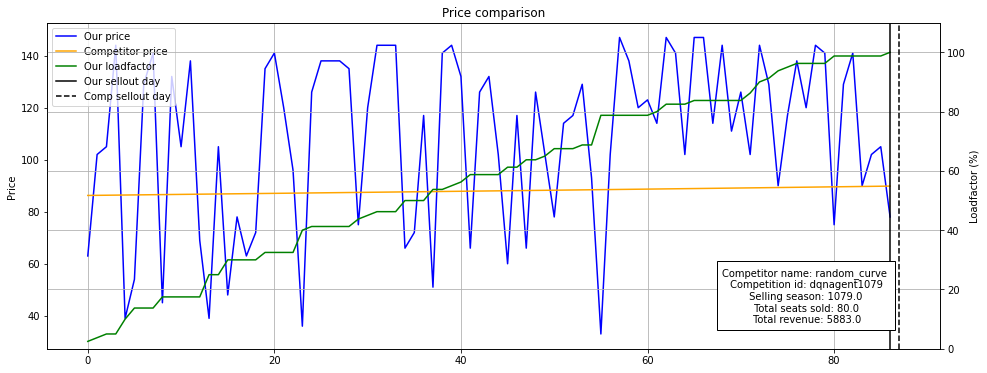

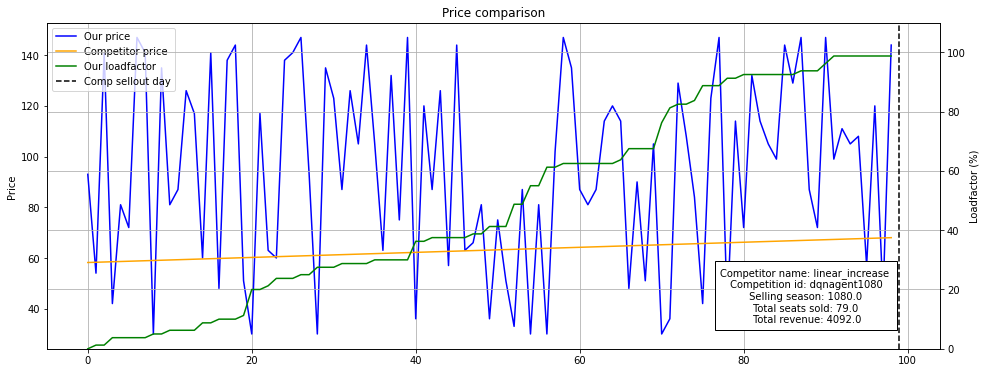

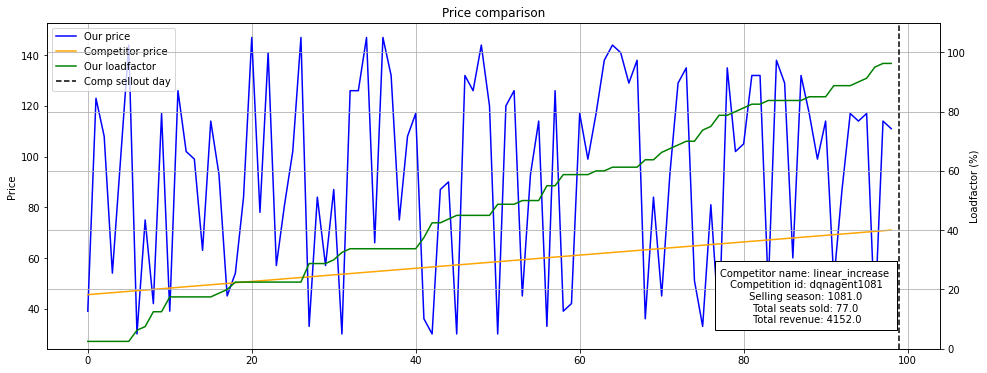

In [18]:
for i in range(5):
    latest_comp_results = dpc_game.competition_results_df['selling_season'].unique()[-6:-1]
    selling_season = latest_comp_results[i]
    competition_id = f'dqnagent{str(int(selling_season))}'
    plot_price_and_loadfactor(dpc_game.competition_results_df, competition_id, selling_season, None)

In [19]:
i=0
comp_strat = np.random.choice(
    a=["random_ranges", "highstart_randomranges", "follower_strategy", "fixed_price", "linear_increase", "random_curve"],
    p=[0.05, 0.05, 0.1, 0.2, 0.3, 0.3]
)
comp_strategy = CompStrategySimulation(comp_strat)
simulator.reset_environment()
time_step = train_env.reset()
logits_df = pd.DataFrame()
last_comp_price = 50

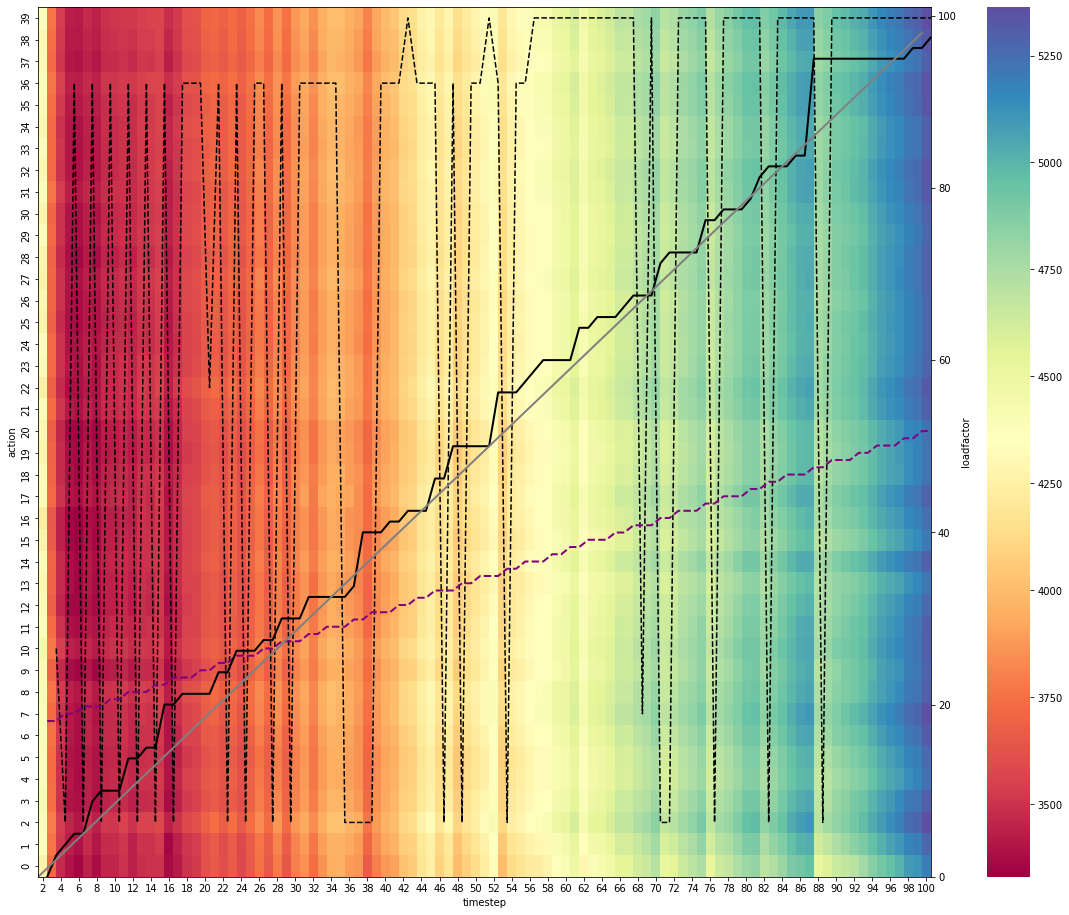

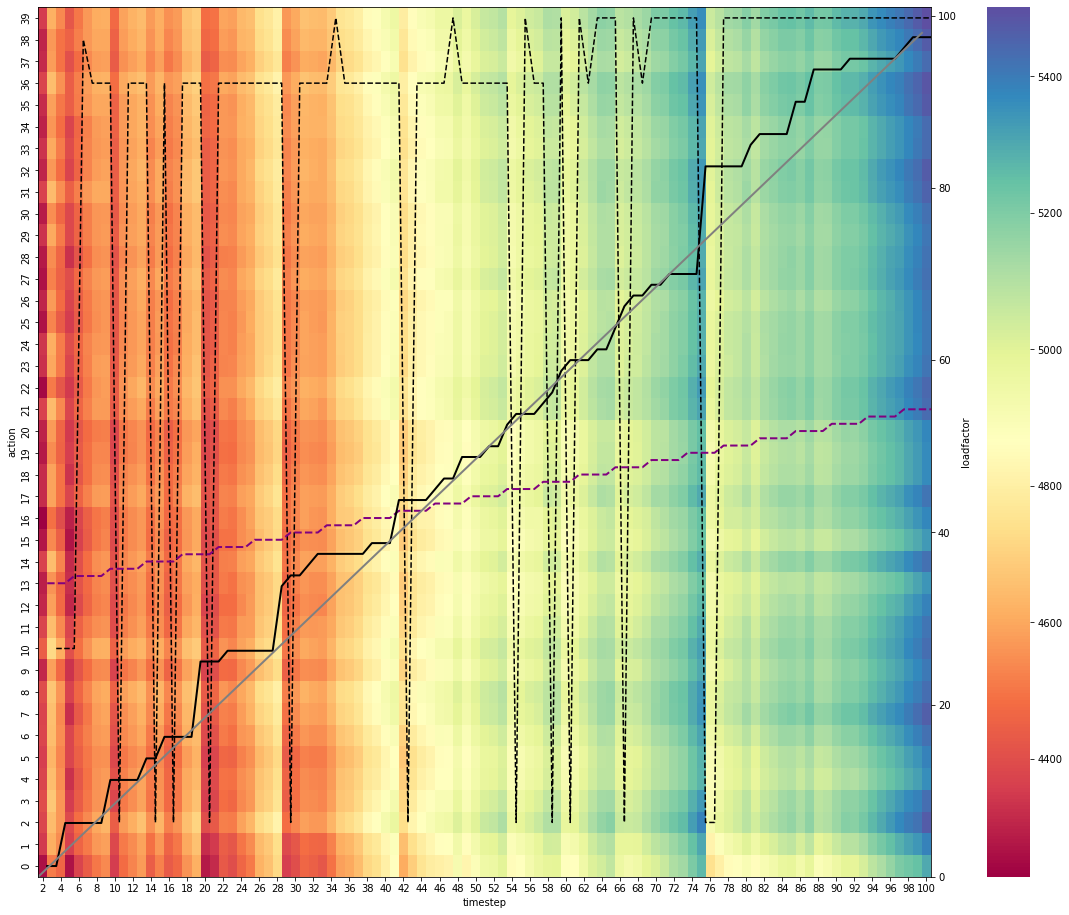

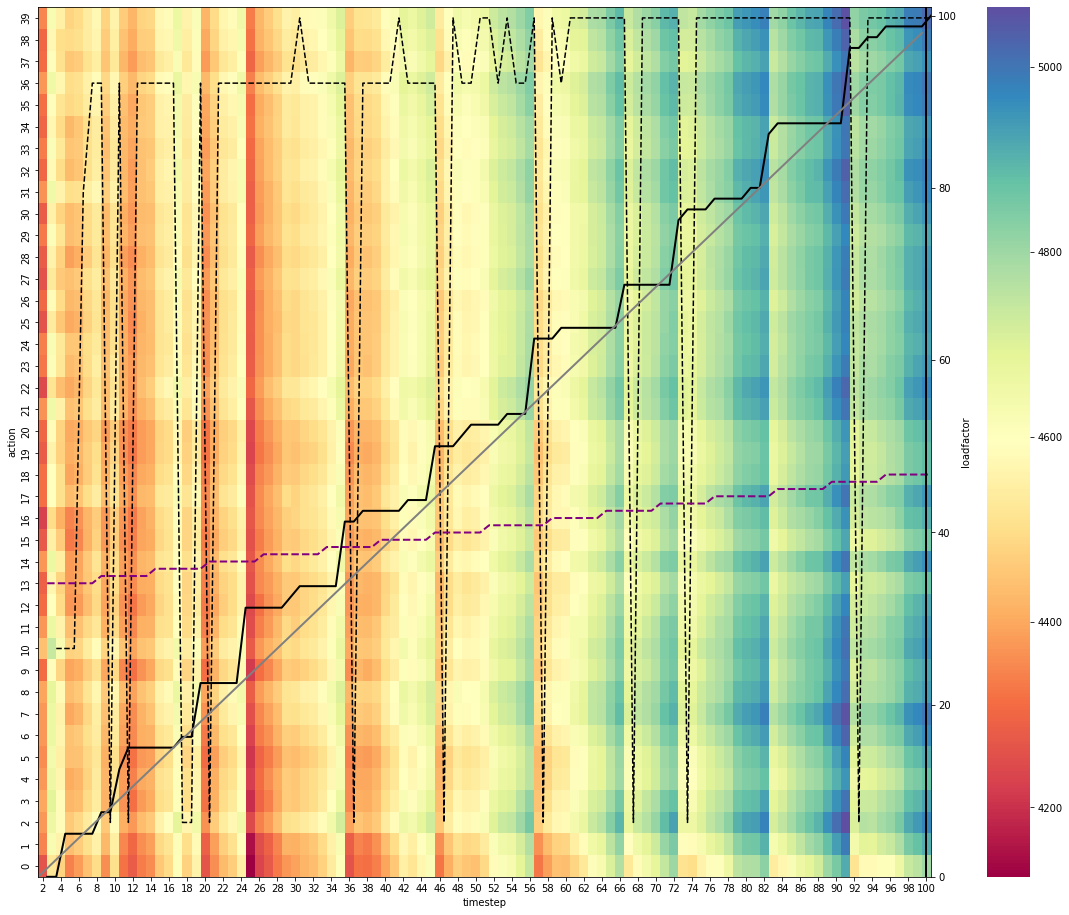

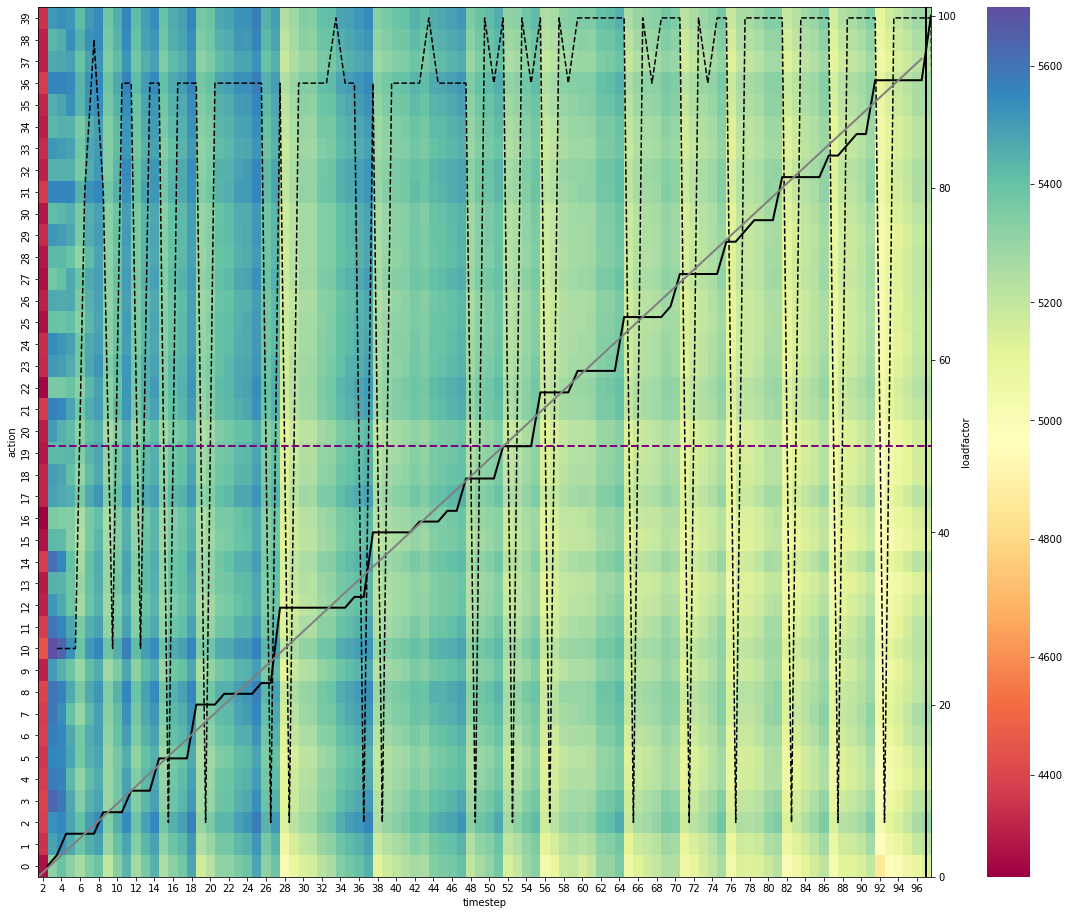

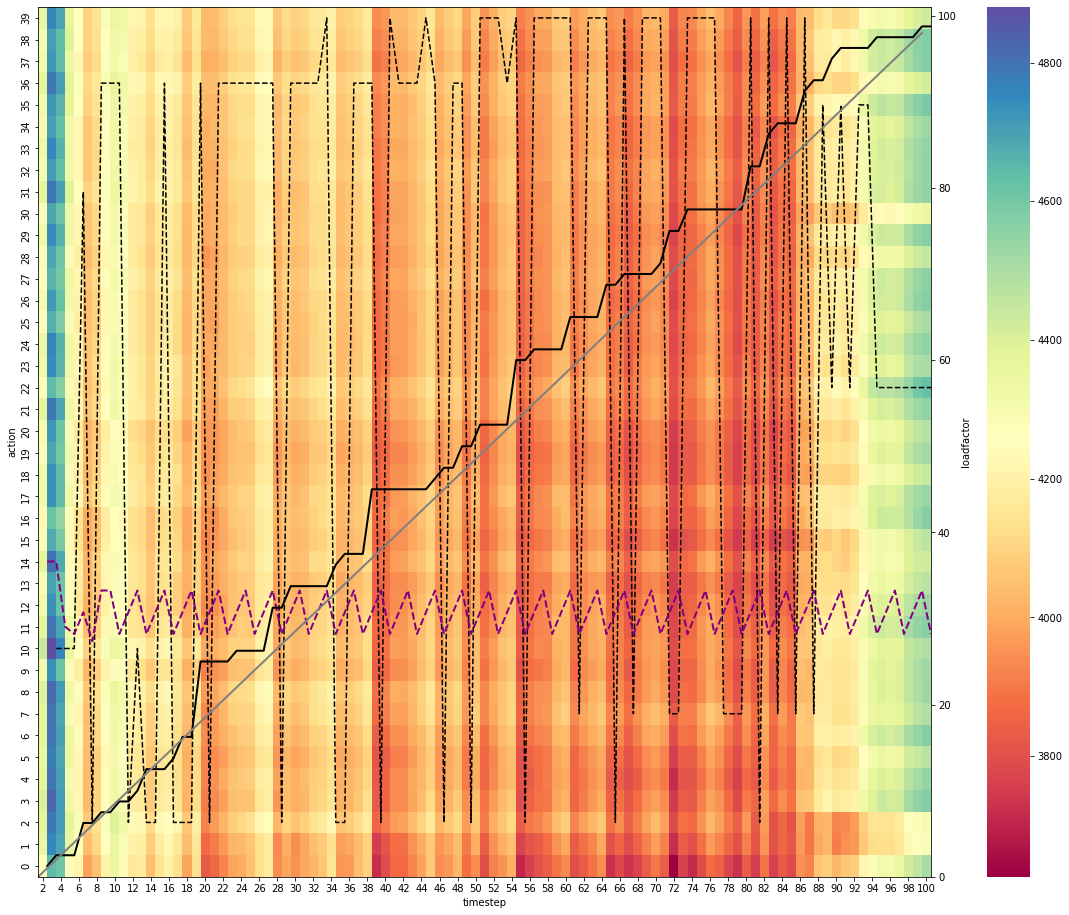

In [20]:
qpolicy = QPolicy(train_env.time_step_spec(), train_env.action_spec(), q_net)

for i in range(5):
    i=0
    comp_strat = np.random.choice(
        a=["random_ranges", "highstart_randomranges", "follower_strategy", "fixed_price", "linear_increase", "random_curve"],
        p=[0.05, 0.05, 0.1, 0.2, 0.3, 0.3]
    )
    comp_strategy = CompStrategySimulation(comp_strat)
    simulator.reset_environment()
    time_step = train_env.reset()
    logits_df = pd.DataFrame()
    last_comp_price = 50
    while int(time_step.step_type) < 2:
        i+=1
        
        #print(f'Selling period: {i}')
        distribution_step = qpolicy.distribution(time_step)
        action_step = qpolicy.action(time_step)

        last_comp_price = comp_strategy.pick_pricepoint(last_comp_price)
        last_price = min_action + int(action_step.action) * action_price_step

        last_demand, _ = simulator.simulate_demand(last_price, last_comp_price)
        #print(f'Our action {int(action_step.action)}, our price {last_price}, comp_price {last_comp_price}, our demand {last_demand}')
        competitor_has_capacity = dpc_game.competitor_has_capacity
        ext_simulator.update(last_price, last_comp_price, last_demand[0], competitor_has_capacity)

        state_logits = pd.DataFrame({
            'timestep': np.repeat(i+1, 40),
            'action': [x for x in range(40)],
            'logit': distribution_step.action.logits[0]
        })

        logits_df = logits_df.append(state_logits)

        time_step = train_env.step(action_step)

    qactions = logits_df.groupby('timestep').agg({'logit': 'idxmax'}).reset_index()

    latest_comp_results = dpc_game.competition_results_df['selling_season'].unique()[-1]
    selling_season = latest_comp_results
    competition_id = f'dqnagent{str(int(selling_season))}'

    # Create temp dataset for competition id and season
    comp_data = dpc_game.competition_results_df[
        (dpc_game.competition_results_df['selling_season'] == selling_season) & 
        (dpc_game.competition_results_df['competition_id'] == competition_id)
    ].reset_index(drop=True)
    comp_data['loadfactor'] = comp_data['demand'].cumsum() / 80 * 100

    plt.figure(figsize=(20, 16))
    ax = sns.heatmap(logits_df.pivot('action', 'timestep', 'logit'), cmap=sns.color_palette("Spectral", as_cmap=True))
    sns.lineplot(x=qactions['timestep'], y=qactions['logit'] + 0.5, color='black', linestyle='--')
    ax.invert_yaxis()

    sns.lineplot(x=comp_data['selling_period'], y=(comp_data['price_competitor'].astype(int) -20) / 3 + 0.5, 
             color='purple', linestyle='--', linewidth=2)

    ax2 = plt.twinx()
    sns.lineplot(x=comp_data['selling_period'], y=comp_data['loadfactor'], ax=ax2, color='black', linewidth=2)
    sns.lineplot(x=[x for x in range(len(comp_data))], y=[x for x in range(len(comp_data))], color='gray', linewidth=2)

    ax2.set_ylim(0, 101)

    # Add vertical lines where inventory sells out
    if comp_data['loadfactor'].iloc[-1] == 100:
        plt.axvline(np.where(comp_data['loadfactor'] == 100)[0][0] + 0.5, 0, 39, color='black', linewidth=2)

    if comp_data['competitor_has_capacity'].sum() < 100:
        plt.axvline(comp_data['competitor_has_capacity'].sum() + 0.5, 0, 39, color='purple', linewidth=2)

In [21]:
comp_strat = np.random.choice(
    a=["random_ranges", "highstart_randomranges", "follower_strategy", "fixed_price", "linear_increase", "random_curve"],
    p=[0.05, 0.05, 0.1, 0.2, 0.3, 0.3]
)
comp_strategy = CompStrategySimulation(comp_strat)

time_step = train_env.reset()
policy_state = agent.collect_policy.get_initial_state(train_env.batch_size)
iterator = iter(dataset)
last_comp_price = 50

action_step = agent.collect_policy.action(time_step)
last_price = min_action + int(action_step.action) * action_price_step

prev_step = time_step
prev_action_step = action_step

for i in range(2000 * 100):
    
    if i % 1000 == 0:
        print(f'Start iteration {i}')
    
    last_comp_price = comp_strategy.pick_pricepoint(last_comp_price)
    last_demand, _ = simulator.simulate_demand(last_price, last_comp_price)
    competitor_has_capacity = dpc_game.competitor_has_capacity

    ext_simulator.update(last_price, last_comp_price, last_demand[0], competitor_has_capacity)
    time_step = train_env.step(action_step)
    action_step = agent.collect_policy.action(time_step)
    last_price = min_action + int(action_step.action) * action_price_step
    
    # Add trajectory and adding to replay buffer + training
    traj = Trajectory(
        prev_step.step_type,
        prev_step.observation,
        prev_action_step.action,
        prev_action_step.info,
        time_step.step_type,
        time_step.reward,
        time_step.discount
    )
    replay_buffer.add_batch(traj)

    # Save step and action for the next round
    prev_step = time_step
    prev_action_step = action_step  
    
    if int(time_step.step_type) == 2:
        comp_strat = np.random.choice(
            a=["random_ranges", "highstart_randomranges", "follower_strategy", "fixed_price", "linear_increase", "random_curve"],
            p=[0.05, 0.05, 0.1, 0.2, 0.3, 0.3]
        )
        comp_strategy = CompStrategySimulation(comp_strat)
        simulator.reset_environment()
    
    if replay_buffer.num_frames() > 5000:
        trajectories, _ = next(iterator)
        loss = agent.train(experience=trajectories)

Start iteration 0
Start iteration 1000
Start iteration 2000
Start iteration 3000
Start iteration 4000
Start iteration 5000
Start iteration 6000
Start iteration 7000
Start iteration 8000
Start iteration 9000
Start iteration 10000
Start iteration 11000
Start iteration 12000
Start iteration 13000
Start iteration 14000
Start iteration 15000
Start iteration 16000
Start iteration 17000
Start iteration 18000
Start iteration 19000
Start iteration 20000
Start iteration 21000
Start iteration 22000
Start iteration 23000
Start iteration 24000
Start iteration 25000
Start iteration 26000
Start iteration 27000
Start iteration 28000
Start iteration 29000
Start iteration 30000
Start iteration 31000
Start iteration 32000
Start iteration 33000
Start iteration 34000
Start iteration 35000
Start iteration 36000
Start iteration 37000
Start iteration 38000
Start iteration 39000
Start iteration 40000
Start iteration 41000
Start iteration 42000
Start iteration 43000
Start iteration 44000
Start iteration 45000
S

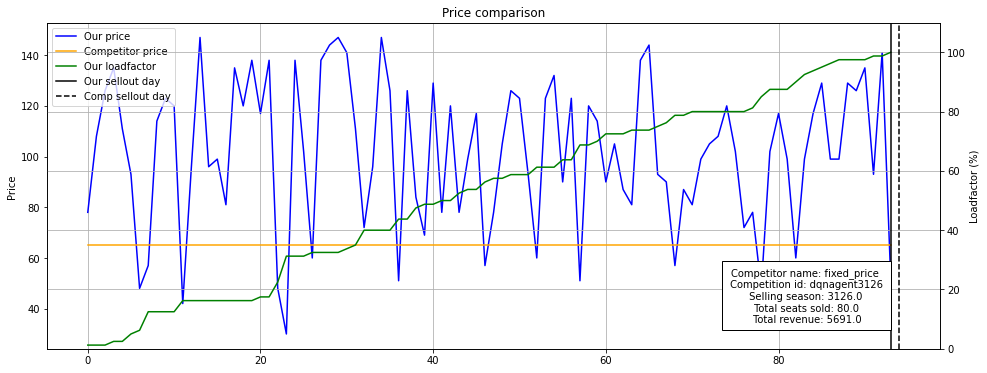

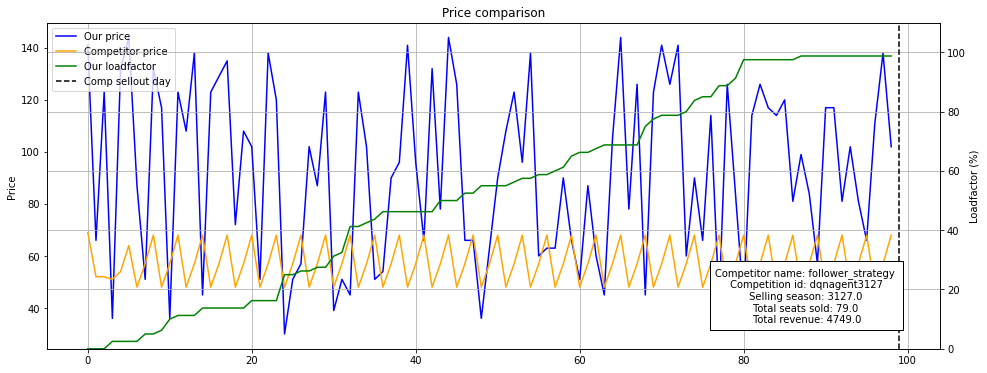

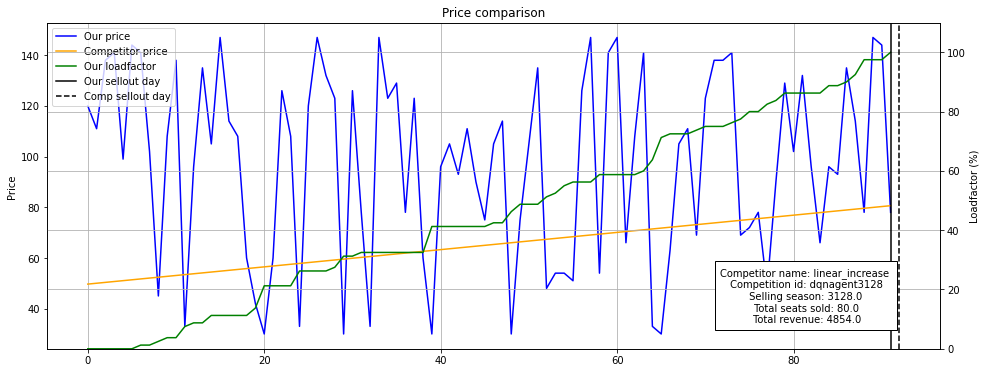

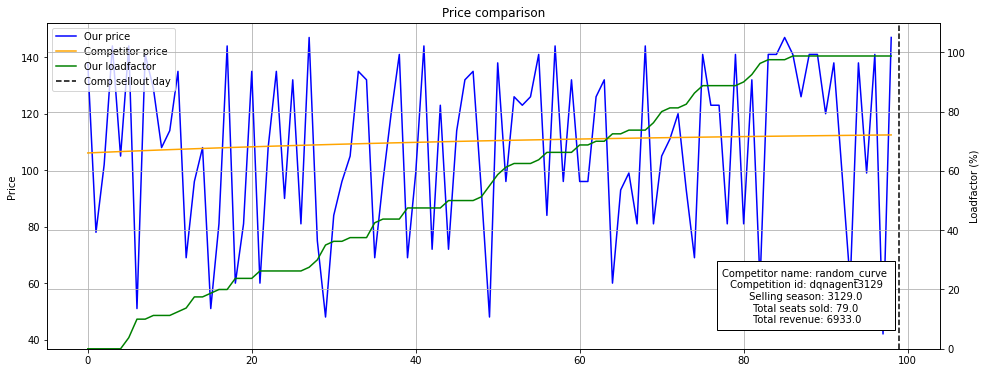

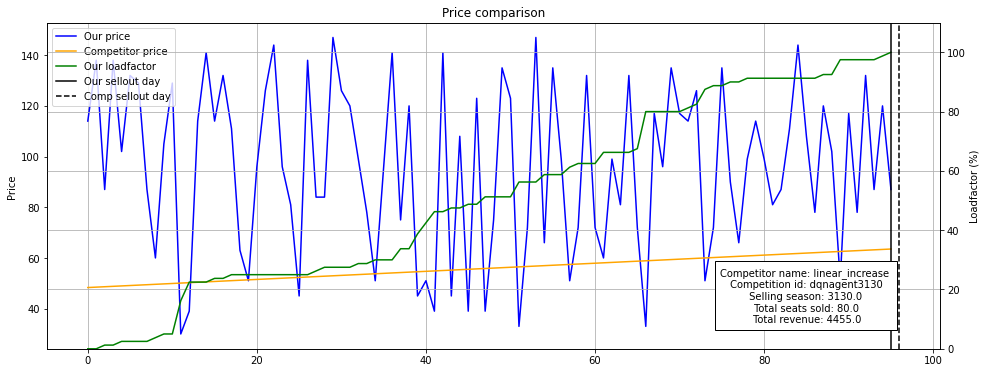

In [22]:
for i in range(5):
    latest_comp_results = dpc_game.competition_results_df['selling_season'].unique()[-6:-1]
    selling_season = latest_comp_results[i]
    competition_id = f'dqnagent{str(int(selling_season))}'
    plot_price_and_loadfactor(dpc_game.competition_results_df, competition_id, selling_season, None)

In [23]:
epsilon_fn(train_step_counter)

<tf.Tensor: shape=(), dtype=float32, numpy=41.590004>

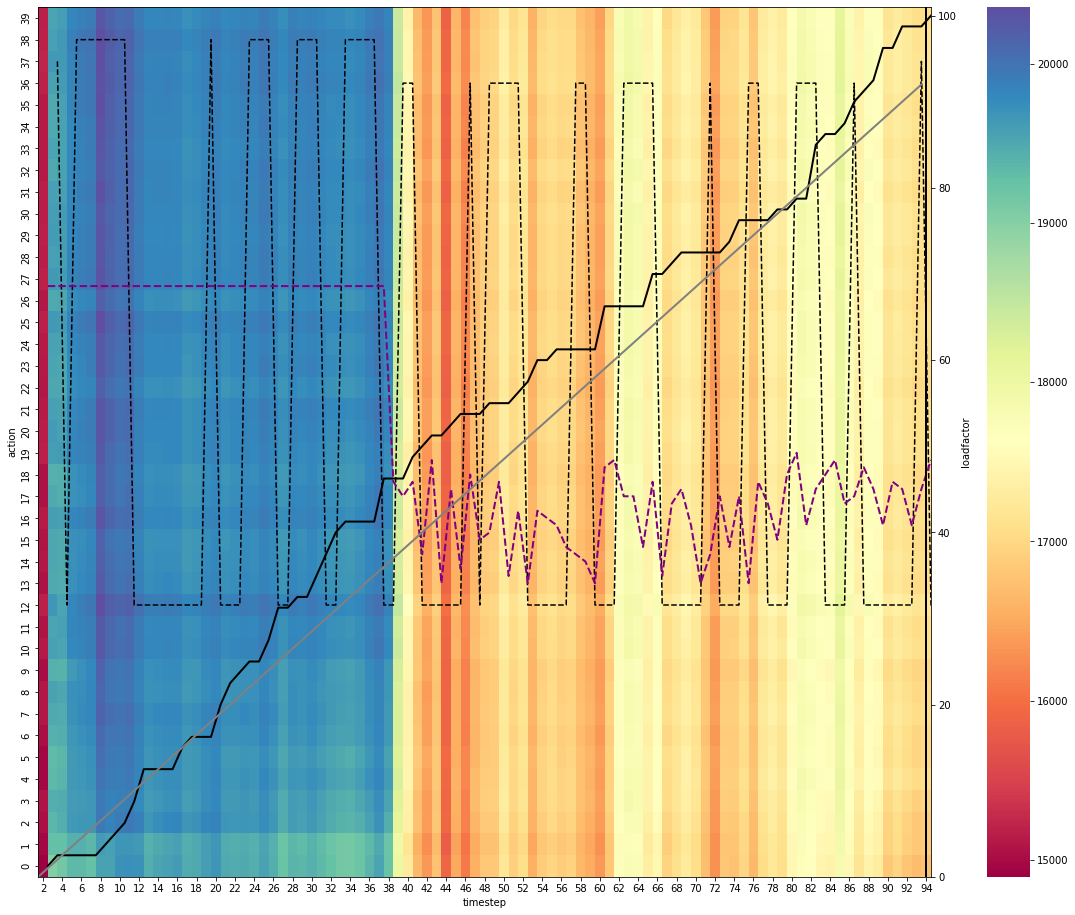

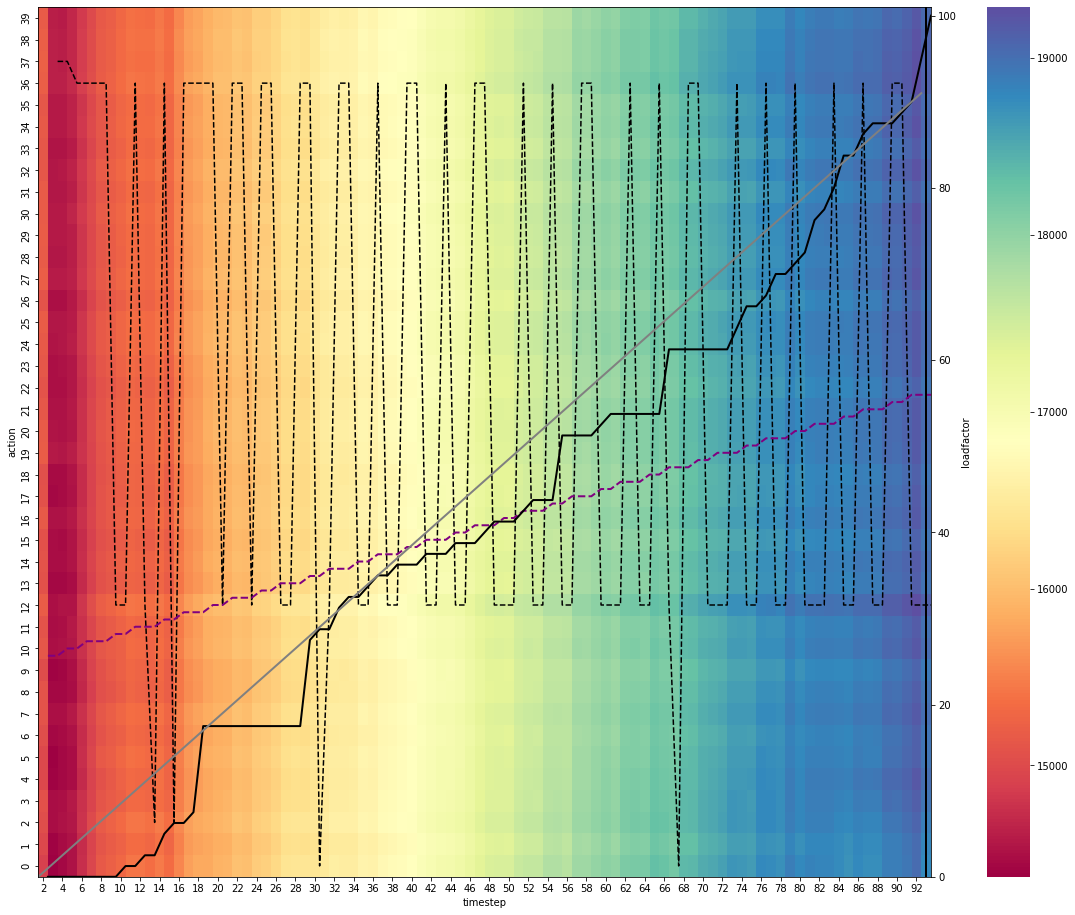

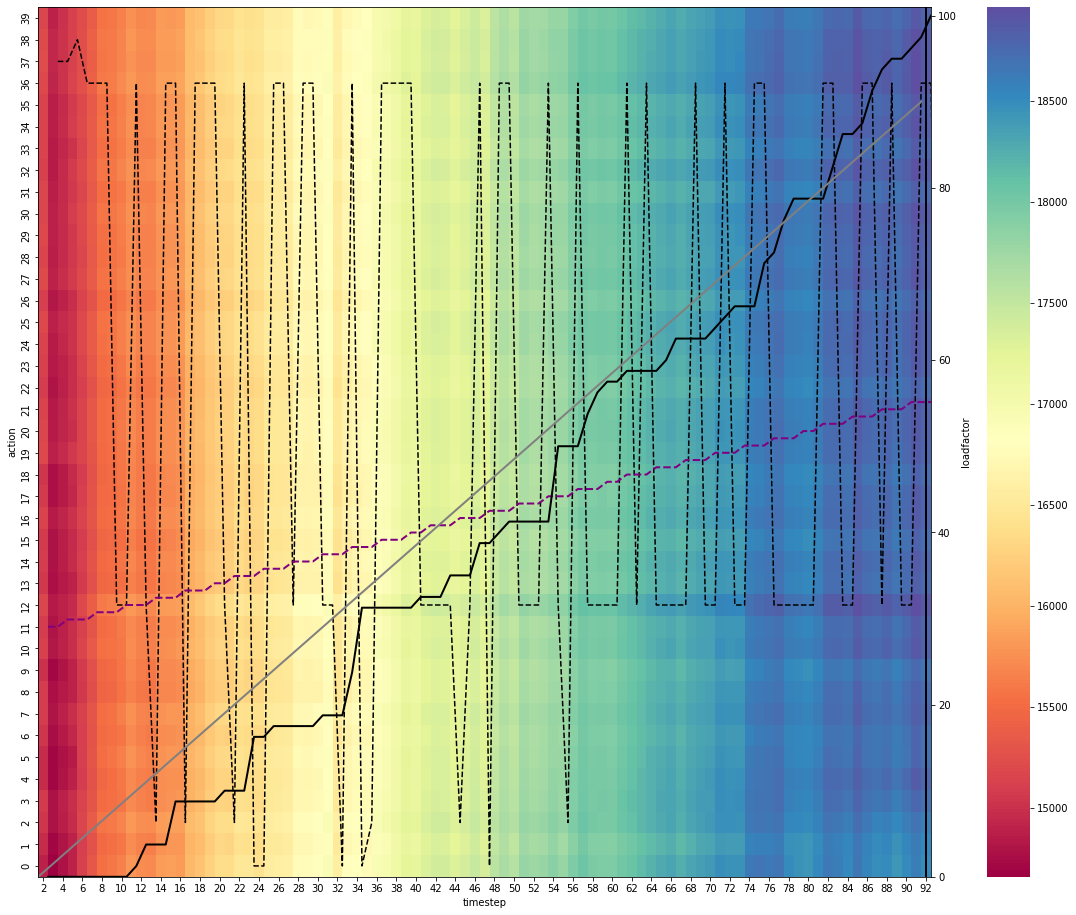

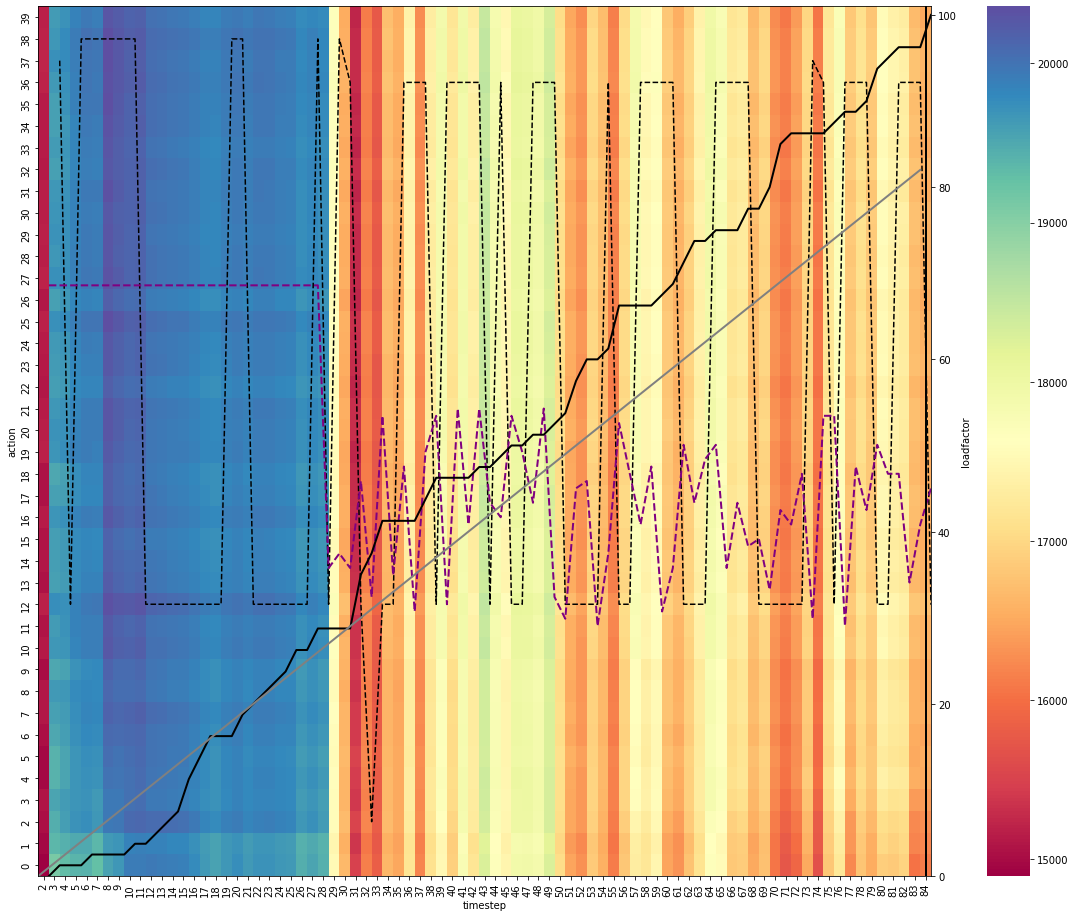

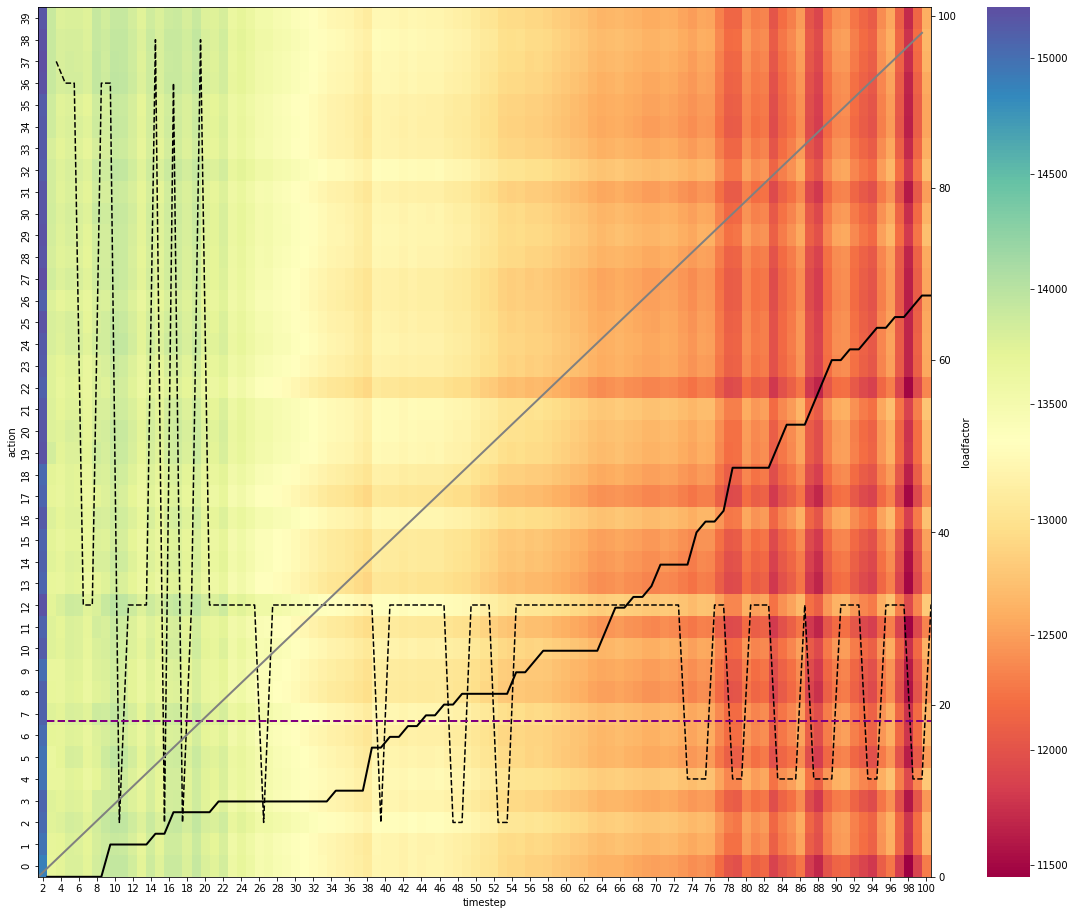

In [24]:
qpolicy = QPolicy(train_env.time_step_spec(), train_env.action_spec(), q_net)

for i in range(5):
    i=0
    comp_strat = np.random.choice(
        a=["random_ranges", "highstart_randomranges", "follower_strategy", "fixed_price", "linear_increase", "random_curve"],
        p=[0.05, 0.05, 0.1, 0.2, 0.3, 0.3]
    )
    comp_strategy = CompStrategySimulation(comp_strat)
    simulator.reset_environment()
    time_step = train_env.reset()
    logits_df = pd.DataFrame()
    last_comp_price = 50
    while int(time_step.step_type) < 2:
        i+=1
        distribution_step = qpolicy.distribution(time_step)
        action_step = qpolicy.action(time_step)

        last_comp_price = comp_strategy.pick_pricepoint(last_comp_price)
        last_price = min_action + int(action_step.action) * action_price_step

        last_demand, _ = simulator.simulate_demand(last_price, last_comp_price)
        competitor_has_capacity = dpc_game.competitor_has_capacity
        ext_simulator.update(last_price, last_comp_price, last_demand[0], competitor_has_capacity)


        state_logits = pd.DataFrame({
            'timestep': np.repeat(i+1, 40),
            'action': [x for x in range(40)],
            'logit': distribution_step.action.logits[0]
        })

        logits_df = logits_df.append(state_logits)

        time_step = train_env.step(action_step)

    qactions = logits_df.groupby('timestep').agg({'logit': 'idxmax'}).reset_index()

    latest_comp_results = dpc_game.competition_results_df['selling_season'].unique()[-1]
    selling_season = latest_comp_results
    competition_id = f'dqnagent{str(int(selling_season))}'

    # Create temp dataset for competition id and season
    comp_data = dpc_game.competition_results_df[
        (dpc_game.competition_results_df['selling_season'] == selling_season) & 
        (dpc_game.competition_results_df['competition_id'] == competition_id)
    ].reset_index(drop=True)
    comp_data['loadfactor'] = comp_data['demand'].cumsum() / 80 * 100

    plt.figure(figsize=(20, 16))
    ax = sns.heatmap(logits_df.pivot('action', 'timestep', 'logit'), cmap=sns.color_palette("Spectral", as_cmap=True))
    sns.lineplot(x=qactions['timestep'], y=qactions['logit'] + 0.5, color='black', linestyle='--')
    ax.invert_yaxis()

    sns.lineplot(x=comp_data['selling_period'], y=(comp_data['price_competitor'].astype(int) -20) / 3 + 0.5, 
             color='purple', linestyle='--', linewidth=2)

    ax2 = plt.twinx()
    sns.lineplot(x=comp_data['selling_period'], y=comp_data['loadfactor'], ax=ax2, color='black', linewidth=2)
    sns.lineplot(x=[x for x in range(len(comp_data))], y=[x for x in range(len(comp_data))], color='gray', linewidth=2)

    ax2.set_ylim(0, 101)

    # Add vertical lines where inventory sells out
    if comp_data['loadfactor'].iloc[-1] == 100:
        plt.axvline(np.where(comp_data['loadfactor'] == 100)[0][0] + 0.5, 0, 39, color='black', linewidth=2)

    if comp_data['competitor_has_capacity'].sum() < 100:
        plt.axvline(comp_data['competitor_has_capacity'].sum() + 0.5, 0, 39, color='purple', linewidth=2)

In [25]:
comp_strat = np.random.choice(
    a=["random_ranges", "highstart_randomranges", "follower_strategy", "fixed_price", "linear_increase", "random_curve"],
    p=[0.05, 0.05, 0.1, 0.2, 0.3, 0.3]
)
comp_strategy = CompStrategySimulation(comp_strat)

time_step = train_env.reset()
policy_state = agent.collect_policy.get_initial_state(train_env.batch_size)
iterator = iter(dataset)
last_comp_price = 50

action_step = agent.collect_policy.action(time_step)
last_price = min_action + int(action_step.action) * action_price_step

prev_step = time_step
prev_action_step = action_step

for i in range(2000 * 100):
    
    if i % 1000 == 0:
        print(f'Start iteration {i}')
    
    last_comp_price = comp_strategy.pick_pricepoint(last_comp_price)
    last_demand, _ = simulator.simulate_demand(last_price, last_comp_price)
    competitor_has_capacity = dpc_game.competitor_has_capacity

    ext_simulator.update(last_price, last_comp_price, last_demand[0], competitor_has_capacity)
    time_step = train_env.step(action_step)
    action_step = agent.collect_policy.action(time_step)
    last_price = min_action + int(action_step.action) * action_price_step
    
    # Add trajectory and adding to replay buffer + training
    traj = Trajectory(
        prev_step.step_type,
        prev_step.observation,
        prev_action_step.action,
        prev_action_step.info,
        time_step.step_type,
        time_step.reward,
        time_step.discount
    )
    replay_buffer.add_batch(traj)

    # Save step and action for the next round
    prev_step = time_step
    prev_action_step = action_step  
    
    if int(time_step.step_type) == 2:
        comp_strat = np.random.choice(
            a=["random_ranges", "highstart_randomranges", "follower_strategy", "fixed_price", "linear_increase", "random_curve"],
            p=[0.05, 0.05, 0.1, 0.2, 0.3, 0.3]
        )
        comp_strategy = CompStrategySimulation(comp_strat)
        simulator.reset_environment()
    
    if replay_buffer.num_frames() > 5000:
        trajectories, _ = next(iterator)
        loss = agent.train(experience=trajectories)

Start iteration 0
Start iteration 1000
Start iteration 2000
Start iteration 3000
Start iteration 4000
Start iteration 5000
Start iteration 6000
Start iteration 7000
Start iteration 8000
Start iteration 9000
Start iteration 10000
Start iteration 11000
Start iteration 12000
Start iteration 13000
Start iteration 14000
Start iteration 15000
Start iteration 16000
Start iteration 17000
Start iteration 18000
Start iteration 19000
Start iteration 20000
Start iteration 21000
Start iteration 22000
Start iteration 23000
Start iteration 24000
Start iteration 25000
Start iteration 26000
Start iteration 27000
Start iteration 28000
Start iteration 29000
Start iteration 30000
Start iteration 31000
Start iteration 32000
Start iteration 33000
Start iteration 34000
Start iteration 35000
Start iteration 36000
Start iteration 37000
Start iteration 38000
Start iteration 39000
Start iteration 40000
Start iteration 41000
Start iteration 42000
Start iteration 43000
Start iteration 44000
Start iteration 45000
S

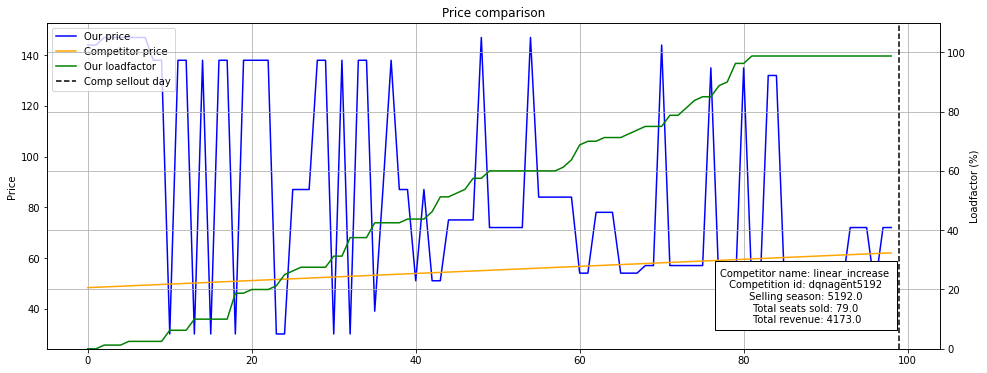

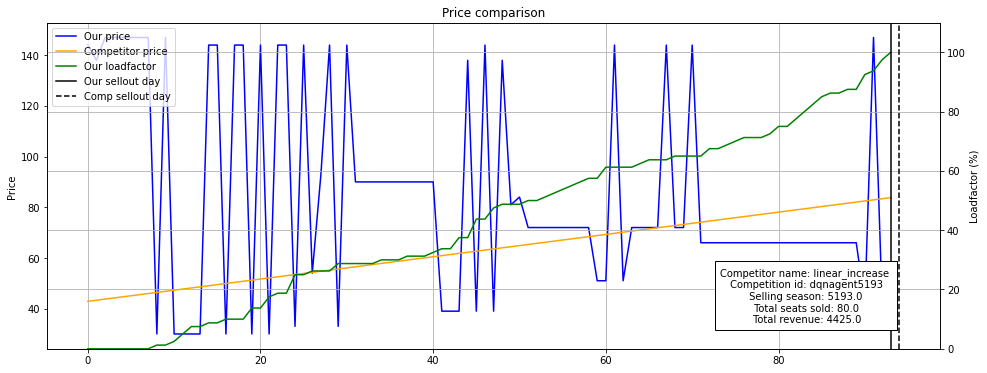

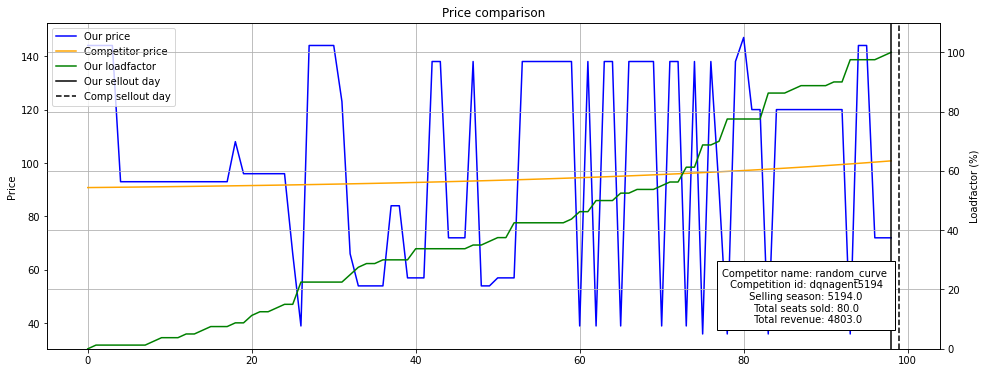

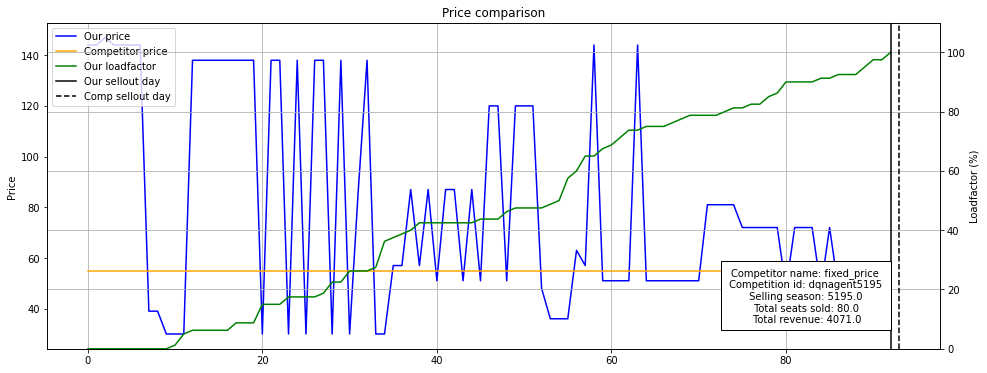

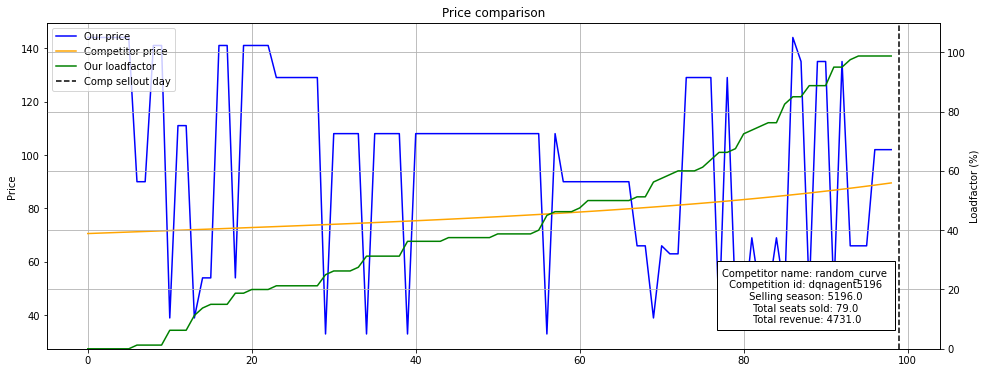

In [26]:
for i in range(5):
    latest_comp_results = dpc_game.competition_results_df['selling_season'].unique()[-6:-1]
    selling_season = latest_comp_results[i]
    competition_id = f'dqnagent{str(int(selling_season))}'
    plot_price_and_loadfactor(dpc_game.competition_results_df, competition_id, selling_season, None)

In [27]:
comp_strat = np.random.choice(
    a=["random_ranges", "highstart_randomranges", "follower_strategy", "fixed_price", "linear_increase", "random_curve"],
    p=[0.05, 0.05, 0.1, 0.2, 0.3, 0.3]
)
comp_strategy = CompStrategySimulation(comp_strat)

time_step = train_env.reset()
policy_state = agent.collect_policy.get_initial_state(train_env.batch_size)
iterator = iter(dataset)
last_comp_price = 50

action_step = agent.collect_policy.action(time_step)
last_price = min_action + int(action_step.action) * action_price_step

prev_step = time_step
prev_action_step = action_step

for i in range(1000 * 100):
    
    if i % 1000 == 0:
        print(f'Start iteration {i}')
    
    last_comp_price = comp_strategy.pick_pricepoint(last_comp_price)
    last_demand, _ = simulator.simulate_demand(last_price, last_comp_price)
    competitor_has_capacity = dpc_game.competitor_has_capacity

    ext_simulator.update(last_price, last_comp_price, last_demand[0], competitor_has_capacity)
    time_step = train_env.step(action_step)
    action_step = agent.collect_policy.action(time_step)
    last_price = min_action + int(action_step.action) * action_price_step
    
    # Add trajectory and adding to replay buffer + training
    traj = Trajectory(
        prev_step.step_type,
        prev_step.observation,
        prev_action_step.action,
        prev_action_step.info,
        time_step.step_type,
        time_step.reward,
        time_step.discount
    )
    replay_buffer.add_batch(traj)

    # Save step and action for the next round
    prev_step = time_step
    prev_action_step = action_step  
    
    if int(time_step.step_type) == 2:
        comp_strat = np.random.choice(
            a=["random_ranges", "highstart_randomranges", "follower_strategy", "fixed_price", "linear_increase", "random_curve"],
            p=[0.05, 0.05, 0.1, 0.2, 0.3, 0.3]
        )
        comp_strategy = CompStrategySimulation(comp_strat)
        simulator.reset_environment()
    
    if replay_buffer.num_frames() > 5000:
        trajectories, _ = next(iterator)
        loss = agent.train(experience=trajectories)

Start iteration 0
Start iteration 1000
Start iteration 2000
Start iteration 3000
Start iteration 4000
Start iteration 5000
Start iteration 6000
Start iteration 7000
Start iteration 8000
Start iteration 9000
Start iteration 10000
Start iteration 11000
Start iteration 12000
Start iteration 13000
Start iteration 14000
Start iteration 15000
Start iteration 16000
Start iteration 17000
Start iteration 18000
Start iteration 19000
Start iteration 20000
Start iteration 21000
Start iteration 22000
Start iteration 23000
Start iteration 24000
Start iteration 25000
Start iteration 26000
Start iteration 27000
Start iteration 28000
Start iteration 29000
Start iteration 30000
Start iteration 31000
Start iteration 32000
Start iteration 33000
Start iteration 34000
Start iteration 35000
Start iteration 36000
Start iteration 37000
Start iteration 38000
Start iteration 39000
Start iteration 40000
Start iteration 41000
Start iteration 42000
Start iteration 43000
Start iteration 44000
Start iteration 45000
S

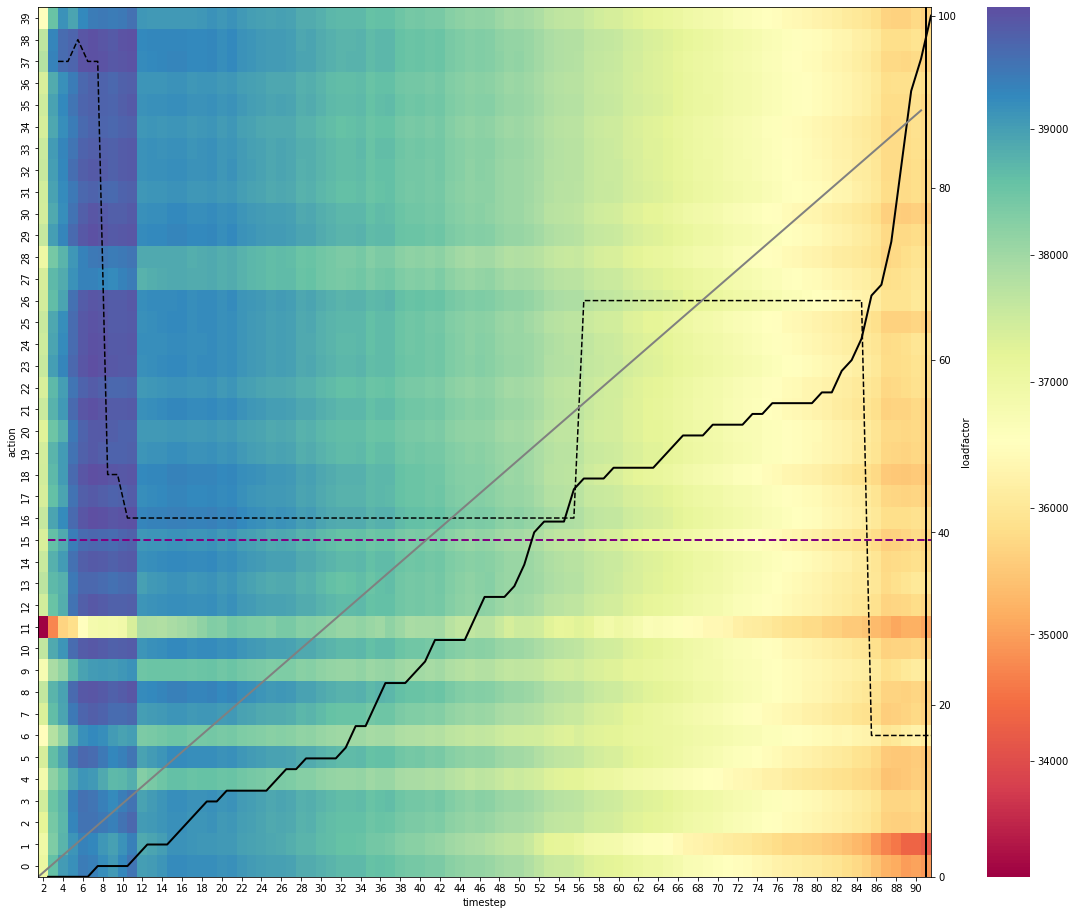

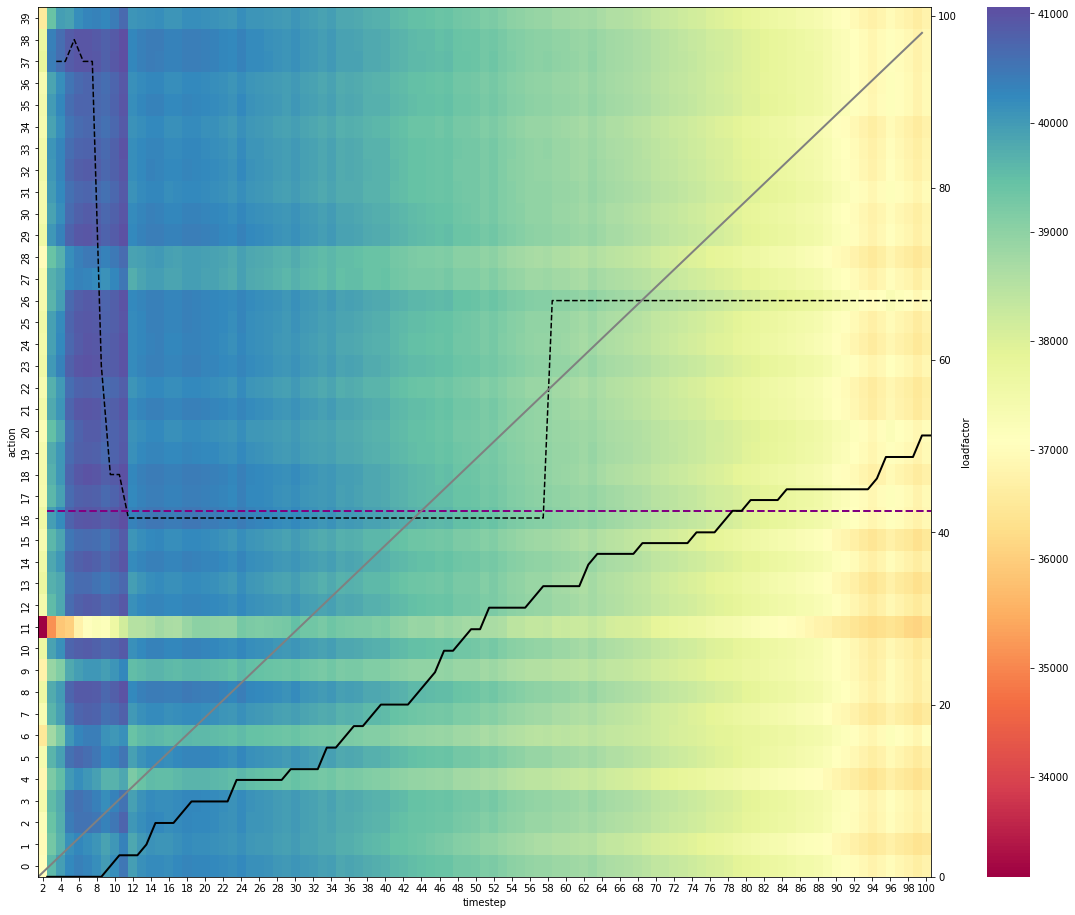

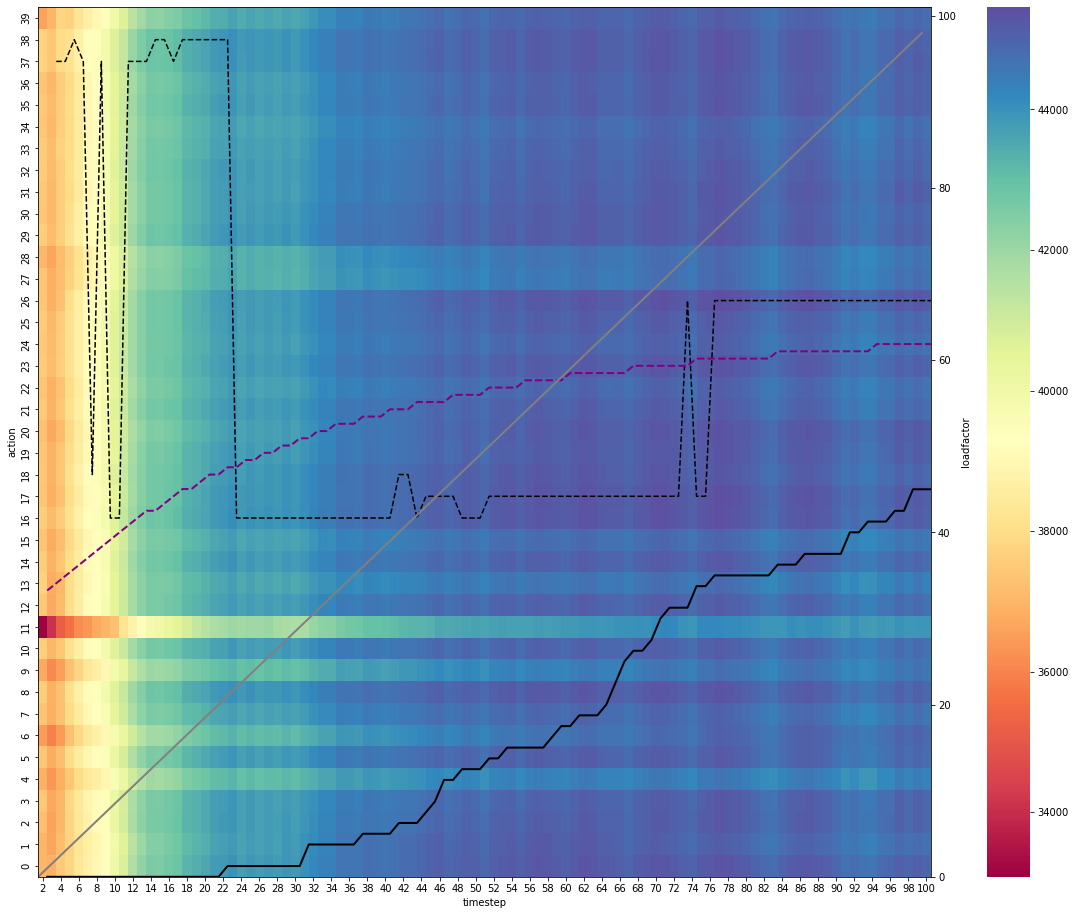

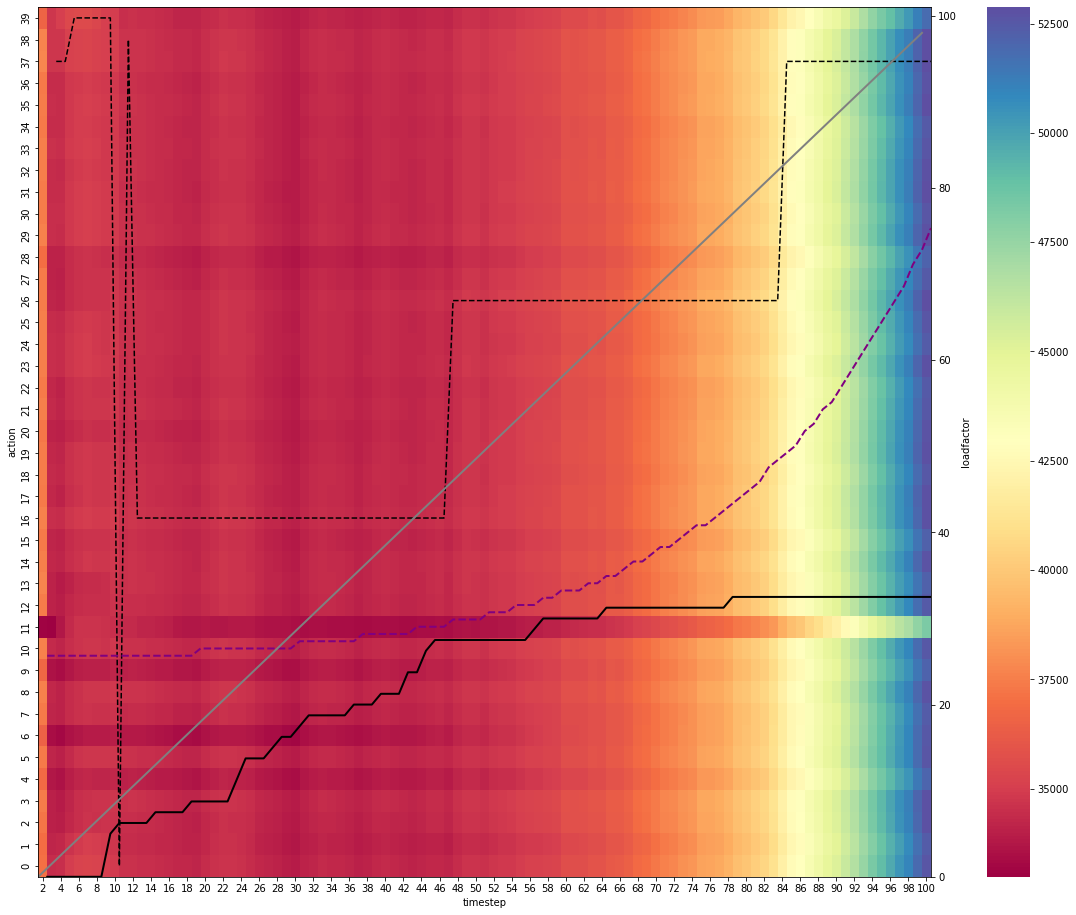

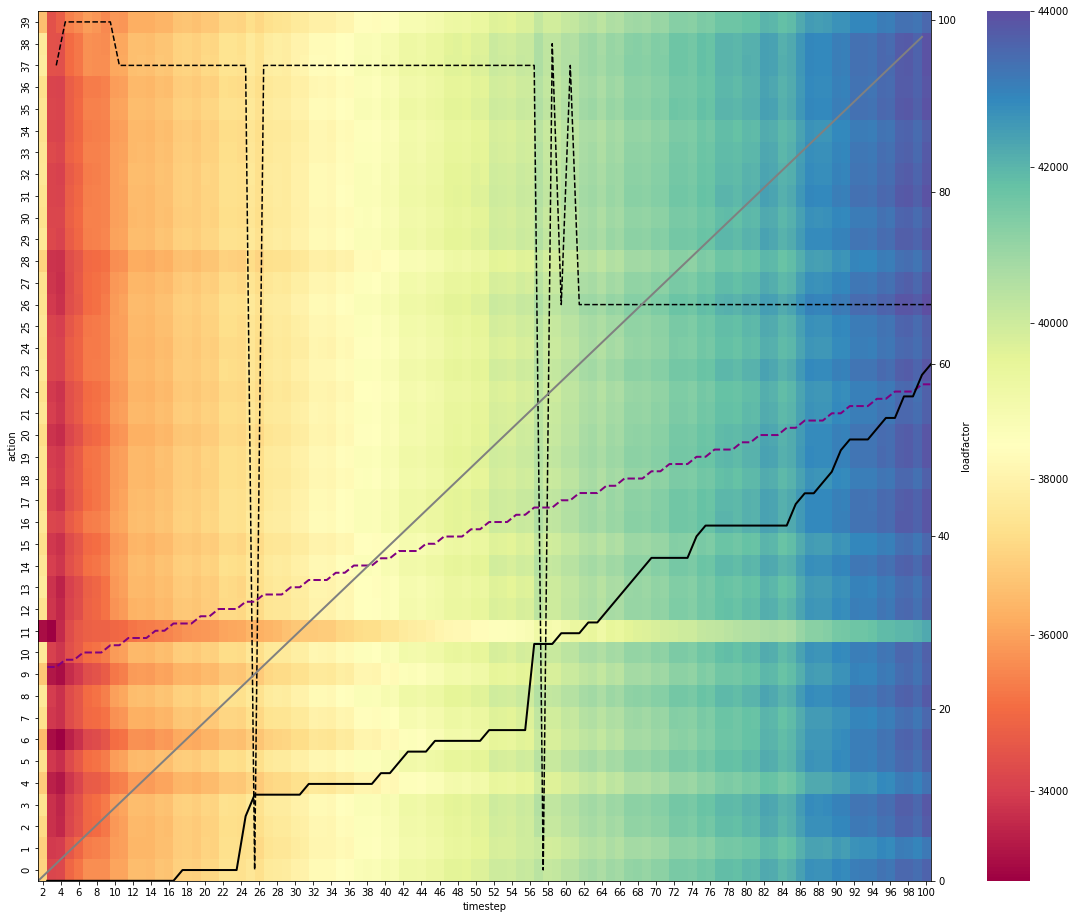

In [28]:
qpolicy = QPolicy(train_env.time_step_spec(), train_env.action_spec(), q_net)

for i in range(5):
    i=0
    comp_strat = np.random.choice(
        a=["random_ranges", "highstart_randomranges", "follower_strategy", "fixed_price", "linear_increase", "random_curve"],
        p=[0.05, 0.05, 0.1, 0.2, 0.3, 0.3]
    )
    comp_strategy = CompStrategySimulation(comp_strat)
    simulator.reset_environment()
    time_step = train_env.reset()
    logits_df = pd.DataFrame()
    last_comp_price = 50
    while int(time_step.step_type) < 2:
        i+=1
        distribution_step = qpolicy.distribution(time_step)
        action_step = qpolicy.action(time_step)

        last_comp_price = comp_strategy.pick_pricepoint(last_comp_price)
        last_price = min_action + int(action_step.action) * action_price_step

        last_demand, _ = simulator.simulate_demand(last_price, last_comp_price)
        competitor_has_capacity = dpc_game.competitor_has_capacity
        ext_simulator.update(last_price, last_comp_price, last_demand[0], competitor_has_capacity)


        state_logits = pd.DataFrame({
            'timestep': np.repeat(i+1, 40),
            'action': [x for x in range(40)],
            'logit': distribution_step.action.logits[0]
        })

        logits_df = logits_df.append(state_logits)

        time_step = train_env.step(action_step)

    qactions = logits_df.groupby('timestep').agg({'logit': 'idxmax'}).reset_index()

    latest_comp_results = dpc_game.competition_results_df['selling_season'].unique()[-1]
    selling_season = latest_comp_results
    competition_id = f'dqnagent{str(int(selling_season))}'

    # Create temp dataset for competition id and season
    comp_data = dpc_game.competition_results_df[
        (dpc_game.competition_results_df['selling_season'] == selling_season) & 
        (dpc_game.competition_results_df['competition_id'] == competition_id)
    ].reset_index(drop=True)
    comp_data['loadfactor'] = comp_data['demand'].cumsum() / 80 * 100

    plt.figure(figsize=(20, 16))
    ax = sns.heatmap(logits_df.pivot('action', 'timestep', 'logit'), cmap=sns.color_palette("Spectral", as_cmap=True))
    sns.lineplot(x=qactions['timestep'], y=qactions['logit'] + 0.5, color='black', linestyle='--')
    ax.invert_yaxis()

    sns.lineplot(x=comp_data['selling_period'], y=(comp_data['price_competitor'].astype(int) -20) / 3 + 0.5, 
             color='purple', linestyle='--', linewidth=2)

    ax2 = plt.twinx()
    sns.lineplot(x=comp_data['selling_period'], y=comp_data['loadfactor'], ax=ax2, color='black', linewidth=2)
    sns.lineplot(x=[x for x in range(len(comp_data))], y=[x for x in range(len(comp_data))], color='gray', linewidth=2)

    ax2.set_ylim(0, 101)

    # Add vertical lines where inventory sells out
    if comp_data['loadfactor'].iloc[-1] == 100:
        plt.axvline(np.where(comp_data['loadfactor'] == 100)[0][0] + 0.5, 0, 39, color='black', linewidth=2)

    if comp_data['competitor_has_capacity'].sum() < 100:
        plt.axvline(comp_data['competitor_has_capacity'].sum() + 0.5, 0, 39, color='purple', linewidth=2)

In [17]:
time_step = train_env.reset()
policy_state = agent.collect_policy.get_initial_state(train_env.batch_size)
iterator = iter(dataset)
last_comp_price = 50

action_step = agent.collect_policy.action(time_step)
last_price = min_action + int(action_step.action) * action_price_step

In [18]:
action_step

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1])>, state=(), info=())

In [21]:
PolicyStep(action=(tf.constant([1])), state=(), info=())

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1])>, state=(), info=())

In [22]:
action_step == PolicyStep(action=(tf.constant([1])), state=(), info=())

True

In [25]:
dpc_game.loadfactor

0

In [30]:
int(replay_buffer.num_frames()) > (replay_buffer_max_size // 2)

False